In [1]:
from __future__ import division

#from IPython.html import widgets # Widget definitions
#from IPython.display import display # Used to display widgets in the notebook
#widget doc http://nbviewer.ipython.org/github/ipython/ipython/tree/master/examples/widgets/
from collections import OrderedDict
#from IPython.display import HTML
from numpy import nan
from numpy.random import randn
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
#from pandas.formats.printing import adjoin
#from pandas_datareader import DataReader
import pandas.util.testing as tm
tm.N = 10
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
pd.options.display.max_columns=80
from io import StringIO 
from io import BytesIO 
import requests
from statsmodels.graphics.api import qqplot
import statsmodels.formula.api as smf
import seaborn as sns   # changes plot styles
%pylab inline
print (sm.version.full_version)
print (pd.__version__)
import IPython
print (IPython.__version__)
print (sns.__version__)
#updated Ipython via git 2/14/2015
#%lsmagic

Populating the interactive namespace from numpy and matplotlib
0.9.0
0.24.1
7.2.0
0.9.0


In [2]:
#turns auto pdb on (toggle)
#%pdb 

In [3]:
#this sets the location index to sheet guid for "most" currently ordered, Lake_Martin_Waterfront main exception
loc2= OrderedDict([('Statewide',1),('Athens',2),('Baldwin_County',3),('Baldwin_Condos',4),('Birmingham',5),('Calhoun',6),('Cherokee',7),('Covington',8),
      ('Cullman',9),('Dothan',10),('Gadsden',11),('Huntsville',12),('Jackson',13),('Lake_Martin',14),('Lee',15),('Marshall',16),
      ('Mobile',17),('Monroe',18),('Montgomery',19),('Morgan',20),('Shoals_Area',21),('Phenix_City',22),('Selma',23),('Talladega',24),('Tuscaloosa',25),('Walker',26),
      ('Wiregrass',27),('Lake_Martin_Waterfront',1244856308)])
loc3=list(loc2.values()) #the GUID loc4[area_nu]
loc4=list(loc2.keys())   #the area name loc4[area_nu]
def get_data(area_nu):
    #get the statewide actual data from Sheet 1 parse dates and select just unit sales
    guid=loc3[area_nu-1] # this is the index number of the sheet
    actdf = pd.read_csv('https://docs.google.com/spreadsheets/d/0Ak_wF7ZGeMmHdFZtQjI1a1hhUWR2UExCa2E4MFhiWWc/export?format=csv&gid=%s' % guid,index_col=0,parse_dates=['Month/Yr'], thousands=',').sort_index() #converts to numbers)
    actdf.rename(columns={'Unit Sales': 'Units'}, inplace=True)
#    locindex=guid-1  # get index for current sheet
    aname=loc4[area_nu-1] #load the location name
    actdf=actdf[['Units']]
    return (actdf,aname)

def fit_line2(x, y):
    X = sm.add_constant(x, prepend=True) #Add a column of ones to allow the calculation of the intercept
    ols_test = sm.OLS(y, X,missing='drop').fit()
    """Return slope, intercept of best fit line."""
    X = sm.add_constant(x)
    return ols_test

def do_projections(actdf,aname):
    fcast_yr=pd.to_datetime('2019-12-31') #the year to forecast
    last_yr=fcast_yr-pd.DateOffset(months=12)
#    print last_yr
    actdf=actdf[:fcast_yr] #this restricts the data to no greater thna the forecast year so mid year stuff can work
    if actdf.index[-1:] < fcast_yr:
        d = pd.DataFrame({'Units' : pd.Series([NaN], index=([fcast_yr]))})
        actdf=actdf.append(d)
#    print actdf
#    give us a full year total
    fullyrs=actdf.resample('A').sum()
    quarters=actdf.resample('Q').sum()
    lastq=quarters.iloc[quarters.index.quarter == 4] #gets the 4th quarter
    lastq.rename(columns={'Units': 'lastqu'}, inplace=True)
#   merge actual units with last4 of prior yr
    merged2=pd.merge( fullyrs, lastq, how='outer', left_index=True, right_index=True)
#    print merged2
#    print merged2[:last_yr]
#   this section for removing bad year and last q data which will then be interpolated unless a select is used to exclude years    
#    blank out due to tax issue 2010 and exagerated bad 2009
#    merged2.loc['2011-12-31','Units'] = NaN
    merged2.loc['2010-12-31','Units'] = NaN
    merged2.loc['2010-12-31','lastqu'] = NaN #(comment out this slightly improves correlation (bham) and improves r2 but, last yr worse
    merged2.loc['2009-12-31','Units'] = NaN
    merged2.loc['2009-12-31','lastqu'] = NaN
    if aname=='Birmingham':
        merged2.loc['2008-12-31','Units'] = NaN
        merged2.loc['2007-12-31','lastqu'] = NaN
#    merged2.loc['2005-12-31','lastqu'] = NaN
    if aname=='Baldwin': #seems to improve results (note that it basically interpolates 2007-2010, kind of a leap!)
        merged2.loc['2008-12-31','Units'] = NaN #for baldwin
        merged2.loc['2008-12-31','lastqu'] = NaN #for baldwin
        merged2.loc['2007-12-31','Units'] = NaN #for baldwin
        merged2.loc['2007-12-31','lastqu'] = NaN #for baldwin
#        merged2.loc['2013-12-31','Units'] = merged2.loc['2013-12-31','Units']-65
#        merged2.loc['2013-12-31','lastqu'] = merged2.loc['2013-12-31','lastqu']-65
#    if aname=='Baldwin Condos': 
#        merged2.loc['2013-12-31','Units'] = merged2.loc['2013-12-31','Units']-65
#        merged2.loc['2013-12-31','lastqu'] = merged2.loc['2013-12-31','lastqu']-65
    #merged2.loc['2006-12-31','Units'] = NaN
    #merged2.loc['2006-12-31','lastqu'] = NaN
#    if aname=='Huntsville'or aname=='Mobile'or aname=='Monroe County':
    if aname=='Huntsville':
        merged2=merged2['2004-12-31':] #to remove pre 2004 at least Bham bettr with all...
    merged2.lastqu=merged2.lastqu.shift() #shifts the lastq forward 1 period for projections
    merged2=merged2.interpolate() #interpolates whatver we blanked out(which got distorted due to tax credit)
#   make forecast units =NaN (undo interpolate)
    merged2['Units'][fcast_yr] = NaN
#    print merged2
    merged2['Uperchg']=np.round((merged2['Units'].pct_change()*100),2)
    merged2['lqperchg']=np.round((merged2['lastqu'].pct_change()*100),2)
# this for SM version of OLS
    ols_test=fit_line2(merged2[:-1].lastqu,merged2[:-1].Units)
    dfform=pd.DataFrame([merged2[:-1].lastqu,merged2[:-1].Units]) #get new DF to feed smformula
    dfform=dfform.T #make columns
#Leaving a lot of debug statements here due to this that messed me up for a while for doing 2018 forecast see:
# https://groups.google.com/d/topic/pystatsmodels/a0XsXIiP5ro/discussion  For a full explanation..
#    print (dfform)
#    print (merged2)
#    print (merged2.iloc[-1:,1:2].shape)
#    print (ols_test.summary())
#    ols_input=(sm.add_constant(merged2.lastqu[-1:], prepend=True))
#    ols_input=(sm.add_constant(merged2.iloc[-1:,1:2], prepend=True))
#    ols_input=(merged2.lastqu[-1:])
    ols_input=np.array([1,merged2.lastqu[-1:].values])
#    print (ols_input)
#    print (ols_input.shape)
#    ols_input=ols_input.iloc[0]
#    print(type(ols_input))
#    yrahead=ols_test.predict(sm2.add_constant(merged2.lastqu[-1:], prepend=True))
    yrahead=ols_test.predict(ols_input)
#    yrahead=ols_test.predict(13209)
    temp=merged2[-1:]
    temp.loc[:,('fcast')]=np.round(yrahead.astype(np.double, 10))
    temp=pd.DataFrame(temp['fcast'])
#    print(temp.head())
    projections=pd.DataFrame(ols_test.fittedvalues)
    projections.columns =['fcast']
    projections=projections.append(temp)
    projections['fcast']=np.round(projections['fcast'])
#    print projections.tail()
    merged2=pd.merge( merged2, projections, how='outer', left_index=True, right_index=True)
    #this takes the prior year error and "corrects" the following year
    merged2['errpercent']=(1-(merged2['Units'])/merged2['fcast'])
    merged2['nfcast']=np.round(merged2['fcast']*(1-merged2['errpercent']).shift())
    merged2['errpercent']=np.round((merged2['errpercent']*100),2)
    merged2['fctperchg']= NaN
    merged2['fctperchg'][-1]=np.round((((merged2['fcast'][-1]/merged2['Units'][-2])-1)*100),2)
    yr=projections['fcast'].values[-1] 
#    print 'year'
#    print yr
    yrsdist= pd.concat([actdf['01/01/2004':'12/01/2009'], actdf['01/01/2011':last_yr]])#Distribution calculation *** fix date
#    print yrsdist.tail(20)
    #calculates the % distribution by month
    totunits=yrsdist['Units'].sum()
    montdist=yrsdist.groupby(lambda x : x.month).sum()
    montdist['mondist'] = (montdist['Units']/totunits)
    montdist #note the distribution by month is stable
    montdist['date']=pd.date_range((fcast_yr) +pd.DateOffset(months=-12), periods=12, freq='MS')
#    print montdist
    montdist=montdist.set_index(['date']).sort_index()
    montdist['fcast']=np.round(montdist['mondist']*yr)
    montdist=montdist.drop(['Units','mondist'],1)
    mergedfcst=pd.merge( actdf, montdist, how='outer', left_index=True, right_index=True)
    mergedfcst=mergedfcst[:-1] #don't know why I get an extra row?
    mergederrs=mergedfcst.copy()
    curr_month=mergederrs['Units'].last_valid_index()
    mergederrs['currerr']=mergedfcst['Units']-mergedfcst['fcast']
    mergederrs['curpercent']=np.round(((mergederrs['currerr']/mergedfcst['fcast'])*100),2)
    mergederrs['fcastcum']=mergederrs['fcast'].cumsum()
    mergederrs['unitscum']=mergederrs['Units'][last_yr:].cumsum() #sets the cumulative units to begin year
    mergederrs['cumerrpercent']=np.round((((mergederrs['unitscum']-mergederrs['fcastcum'])/(mergederrs['fcastcum']))*100),2)
    mergederrs['last_yr_u']=mergederrs['Units'].shift(12)
    mergederrs['last_yrcum_u']=mergederrs['last_yr_u'][last_yr:].cumsum()
    mergederrs['cumthisyrtolastpr']=((mergederrs['unitscum']-mergederrs['last_yrcum_u'])/(mergederrs['last_yrcum_u']))*100
    mergederrs['cumfcasttolstpr']=np.round((((mergederrs['fcastcum']-mergederrs['last_yrcum_u'])/(mergederrs['last_yrcum_u']))*100),2)
    return(dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month)

def regressplot(aname,ols_test):
    plt.clf()
    print (aname)
    intercept, slope = ols_test.params 
    plt.plot(merged2[:-1].lastqu,merged2[:-1].Units, 'bo')
    plt.hold(True)
    x = np.array([merged2[:-1].lastqu.min(), merged2[:-1].lastqu.max()])
    y = intercept + slope * x
    plt.plot(x, y, 'r-')
    regress=plt.show()
    return aname,regress

def reg_act(aname,merged2):
#this just shows the regression results with current yr fcast
#    plt.clf()
#    print aname
    fig = plt.figure(figsize=(6,4))
#    plt.rcParams['figure.figsize'] = 10, 10
    ax=fullyrs.Units.plot()
    ax=merged2.fcast.plot(style='r')
    plt_reg_act= plt.show()
    return aname,plt_reg_act
#make summary
def get_sumdf(area_tabs):  # perhaps you can name better?
    actdf,aname = get_data(area_tabs)
#    print (aname,actdf)
    dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
    sumdf=mergederrs
    sumdf['name']=aname
    print ('{0} projected 2018 = {1:,}, {2}% difference from 2017 actual of = {3:,}'.format(aname, int(sumdf['fcastcum'][-1]),
            sumdf['cumfcasttolstpr'][-1],int(sumdf['last_yrcum_u'][-1])))
    return sumdf

def get_yrsum(area_tabs):  # perhaps you can name better?
    actdf, aname = get_data(area_tabs)
    dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
    sumdf=mergederrs[-1:]
    sumdf['name']=aname
    return sumdf

In [4]:
actdf, aname = get_data(19)
actdf2, aname2 = get_data(23)
actdf3 = actdf+actdf2.dropna()
fform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
print("\n".join([str(t[0]) for t in montdist.values]))
aname

292.0
317.0
410.0
399.0
453.0
463.0
463.0
442.0
383.0
385.0
346.0
351.0


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

'Montgomery'

In [176]:
actdf3

Units
Month/Yr         
2000-05-01    NaN
2000-06-01    NaN
2000-07-01    NaN
2000-08-01    NaN
2000-09-01    NaN
2000-10-01    NaN
2000-11-01    NaN
2000-12-01    NaN
2001-01-01    NaN
2001-02-01    NaN
2001-03-01    NaN
2001-04-01    NaN
2001-05-01    NaN
2001-06-01  390.0
2001-07-01  373.0
2001-08-01  394.0
2001-09-01  258.0
2001-10-01  271.0
2001-11-01  312.0
2001-12-01  277.0
2002-01-01  255.0
2002-02-01  284.0
2002-03-01  337.0
2002-04-01  353.0
2002-05-01  397.0
2002-06-01  342.0
2002-07-01  414.0
2002-08-01  419.0
2002-09-01  330.0
2002-10-01  338.0
...           ...
2016-07-01  384.0
2016-08-01  418.0
2016-09-01  359.0
2016-10-01  319.0
2016-11-01  310.0
2016-12-01  318.0
2017-01-01  316.0
2017-02-01  262.0
2017-03-01  375.0
2017-04-01  389.0
2017-05-01  492.0
2017-06-01  438.0
2017-07-01  406.0
2017-08-01  400.0
2017-09-01  354.0
2017-10-01  369.0
2017-11-01  367.0
2017-12-01  355.0
2018-01-01  243.0
2018-02-01  282.0
2018-03-01  426.0
2018-04-01  404.0
2018-05-01    NaN
2018-06-01    NaN
2018-07-01    NaN
2018-08-01    NaN
2018-09-01    NaN
2018-10-01    NaN
2018-11-01    NaN
2018-12-01    NaN

[224 rows x 1 columns]

In [60]:
#from IPython.display import Image
#Image(filename='ACRE_SmallLogo14.png')

# <img src="ACRE_SmallLogo14.png">

# Summary (methodology)

# Statewide full year 2018 forecast summary

In [78]:
#make summary dataframe with last year, this year and forecast with fullyear summary
#area_tabs=[12]
#area_tabs=['11','21','20','1','10','5','15','19','25','17'] # the tab numbers
area_tabs=list(map(int, range(1, 29)))
sumdf2=pd.concat([get_yrsum(area_tab) for area_tab in area_tabs])
#sumdf2=([get_sumdf(area_tab)])
sumdf2.head(30)

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp inste

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp inste

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying t

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp inste

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp inste

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp inste

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Units   fcast  currerr  curpercent  fcastcum  unitscum  \
2019-12-01    NaN  4450.0      NaN         NaN   60385.0       NaN   
2019-12-01    NaN   161.0      NaN         NaN    2033.0       NaN   
2019-12-01    NaN   534.0      NaN         NaN    7073.0       NaN   
2019-12-01    NaN   117.0      NaN         NaN    1495.0       NaN   
2019-12-01    NaN  1246.0      NaN         NaN   16647.0       NaN   
2019-12-01    NaN   129.0      NaN         NaN    1784.0       NaN   
2019-12-01    NaN    14.0      NaN         NaN     252.0       NaN   
2019-12-01    NaN    22.0      NaN         NaN     287.0       NaN   
2019-12-01    NaN    59.0      NaN         NaN     879.0       NaN   
2019-12-01    NaN   108.0      NaN         NaN    1501.0       NaN   
2019-12-01    NaN    62.0      NaN         NaN     929.0       NaN   
2019-12-01    NaN   577.0      NaN         NaN    7542.0       NaN   
2019-12-01    NaN    21.0      NaN         NaN     281.0       NaN   
2019-12-01    NaN    43.0      NaN         NaN     685.0       NaN   
2019-12-01    NaN   141.0      NaN         NaN    2110.0       NaN   
2019-12-01    NaN    69.0      NaN         NaN     948.0       NaN   
2019-12-01    NaN   335.0      NaN         NaN    4575.0       NaN   
2019-12-01    NaN     8.0      NaN         NaN      98.0       NaN   
2019-12-01    NaN   351.0      NaN         NaN    4704.0       NaN   
2019-12-01    NaN   109.0      NaN         NaN    1496.0       NaN   
2019-12-01    NaN   140.0      NaN         NaN    1843.0       NaN   
2019-12-01    NaN    86.0      NaN         NaN    1132.0       NaN   
2019-12-01    NaN     5.0      NaN         NaN      73.0       NaN   
2019-12-01    NaN    37.0      NaN         NaN     520.0       NaN   
2019-12-01    NaN   191.0      NaN         NaN    2687.0       NaN   
2019-12-01    NaN    87.0      NaN         NaN    1164.0       NaN   
2019-12-01    NaN    72.0      NaN         NaN    1056.0       NaN   
2019-12-01    NaN    16.0      NaN         NaN     288.0       NaN   

            cumerrpercent  last_yr_u  last_yrcum_u  cumthisyrtolastpr  \
2019-12-01            NaN     4303.0       61062.0                NaN   
2019-12-01            NaN      143.0        1870.0                NaN   
2019-12-01            NaN      450.0        6845.0                NaN   
2019-12-01            NaN       97.0        1549.0                NaN   
2019-12-01            NaN     1184.0       15844.0                NaN   
2019-12-01            NaN      116.0        1694.0                NaN   
2019-12-01            NaN       14.0         251.0                NaN   
2019-12-01            NaN       24.0         269.0                NaN   
2019-12-01            NaN       64.0         866.0                NaN   
2019-12-01            NaN      114.0        1515.0                NaN   
2019-12-01            NaN       64.0         898.0                NaN   
2019-12-01            NaN      524.0        7622.0                NaN   
2019-12-01            NaN       24.0         291.0                NaN   
2019-12-01            NaN       38.0         675.0                NaN   
2019-12-01            NaN      134.0        2104.0                NaN   
2019-12-01            NaN       66.0         922.0                NaN   
2019-12-01            NaN      340.0        4613.0                NaN   
2019-12-01            NaN        3.0         103.0                NaN   
2019-12-01            NaN      316.0        4666.0                NaN   
2019-12-01            NaN      108.0        1643.0                NaN   
2019-12-01            NaN      141.0        1956.0                NaN   
2019-12-01            NaN       74.0        1148.0                NaN   
2019-12-01            NaN       10.0         121.0                NaN   
2019-12-01            NaN       29.0         509.0                NaN   
2019-12-01            NaN      187.0        2671.0                NaN   
2019-12-01            NaN       78.0         995.0                NaN   
2019-12-01

In [62]:
sumdf2.to_csv('2018fcast.csv')

In [63]:
#make summary
#area_tabs=[25]
#area_tabs=[1,5,8,25,16,3,17,19,22,27] # the tab numbers
area_tabs=list(map(int, range(1, 29)))
sumdf2=pd.concat([get_sumdf(area_tab) for area_tab in area_tabs])
#sumdf2=([get_sumdf(area_tab)])
#sumdf2.tail(12)

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Statewide projected 2018 = 60,385, -1.11% difference from 2017 actual of = 61,062


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Athens projected 2018 = 2,033, 8.72% difference from 2017 actual of = 1,870


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Baldwin_County projected 2018 = 7,073, 3.33% difference from 2017 actual of = 6,845


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Baldwin_Condos projected 2018 = 1,495, -3.49% difference from 2017 actual of = 1,549


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Birmingham projected 2018 = 16,647, 5.07% difference from 2017 actual of = 15,844


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Calhoun projected 2018 = 1,784, 5.31% difference from 2017 actual of = 1,694


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Cherokee projected 2018 = 252, 0.4% difference from 2017 actual of = 251


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Covington projected 2018 = 287, 6.69% difference from 2017 actual of = 269


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Cullman projected 2018 = 879, 1.5% difference from 2017 actual of = 866


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Dothan projected 2018 = 1,471, -2.13% difference from 2017 actual of = 1,503


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Gadsden projected 2018 = 929, 3.45% difference from 2017 actual of = 898


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Huntsville projected 2018 = 7,542, -1.05% difference from 2017 actual of = 7,622


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Jackson projected 2018 = 281, -3.44% difference from 2017 actual of = 291


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lake_Martin projected 2018 = 685, 1.48% difference from 2017 actual of = 675


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lee projected 2018 = 2,110, 0.29% difference from 2017 actual of = 2,104


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Marshall projected 2018 = 948, 2.82% difference from 2017 actual of = 922


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Mobile projected 2018 = 4,575, -0.82% difference from 2017 actual of = 4,613


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Monroe projected 2018 = 98, -4.85% difference from 2017 actual of = 103


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Montgomery projected 2018 = 4,704, 0.81% difference from 2017 actual of = 4,666


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Morgan projected 2018 = 1,496, -8.95% difference from 2017 actual of = 1,643


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Shoals_Area projected 2018 = 1,843, -5.78% difference from 2017 actual of = 1,956


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Phenix_City projected 2018 = 1,132, -1.39% difference from 2017 actual of = 1,148


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Selma projected 2018 = 73, -39.67% difference from 2017 actual of = 121


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Talladega projected 2018 = 520, 2.16% difference from 2017 actual of = 509


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Tuscaloosa projected 2018 = 2,687, 0.6% difference from 2017 actual of = 2,671


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Walker projected 2018 = 1,164, 16.98% difference from 2017 actual of = 995


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Wiregrass projected 2018 = 1,056, -4.35% difference from 2017 actual of = 1,104
Lake_Martin_Waterfront projected 2018 = 288, -3.03% difference from 2017 actual of = 297


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

In [64]:
sumdf2.head()

Units  fcast  currerr  curpercent  fcastcum  unitscum  \
2000-01-01  1603.0    NaN      NaN         NaN       NaN       NaN   
2000-02-01  1949.0    NaN      NaN         NaN       NaN       NaN   
2000-03-01  2560.0    NaN      NaN         NaN       NaN       NaN   
2000-04-01  2307.0    NaN      NaN         NaN       NaN       NaN   
2000-05-01  2796.0    NaN      NaN         NaN       NaN       NaN   

            cumerrpercent  last_yr_u  last_yrcum_u  cumthisyrtolastpr  \
2000-01-01            NaN        NaN           NaN                NaN   
2000-02-01            NaN        NaN           NaN                NaN   
2000-03-01            NaN        NaN           NaN                NaN   
2000-04-01            NaN        NaN           NaN                NaN   
2000-05-01            NaN        NaN           NaN                NaN   

            cumfcasttolstpr       name  
2000-01-01              NaN  Statewide  
2000-02-01              NaN  Statewide  
2000-03-01              NaN  Statewide  
2000-04-01              NaN  Statewide  
2000-05-01              NaN  Statewide

In [75]:
#make summary by month
#area_tabs=2
#sumdf=get_sumdf(area_tabs)
area_tabs=list(map(int, range(1, 29)))
#sumdf=pd.concat([sumdf],[get_sumdf(area_tab) for area_tab in area_tabs])
for area_tab in area_tabs:
    sumdf=get_sumdf(area_tab) 
#    print(sumdf)
    sumdf2=pd.concat([sumdf[-1:]])
    print ('{0} projected 2018 = {1:,}, {2}% over 2017 actual of = {3:,}'.format(sumdf.name[1], int(sumdf['fcastcum'][-1]),
        sumdf['cumfcasttolstpr'][-1],int(sumdf['last_yrcum_u'][-1])))
#sumdf2=([get_sumdf(area_tab)])
sumdf.tail(12)

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Statewide projected 2018 = 60,385, -1.11% difference from 2017 actual of = 61,062
Statewide projected 2018 = 60,385, -1.11% over 2017 actual of = 61,062


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Athens projected 2018 = 2,033, 8.72% difference from 2017 actual of = 1,870
Athens projected 2018 = 2,033, 8.72% over 2017 actual of = 1,870


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Baldwin_County projected 2018 = 7,073, 3.33% difference from 2017 actual of = 6,845
Baldwin_County projected 2018 = 7,073, 3.33% over 2017 actual of = 6,845


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Baldwin_Condos projected 2018 = 1,495, -3.49% difference from 2017 actual of = 1,549
Baldwin_Condos projected 2018 = 1,495, -3.49% over 2017 actual of = 1,549


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Birmingham projected 2018 = 16,647, 5.07% difference from 2017 actual of = 15,844
Birmingham projected 2018 = 16,647, 5.07% over 2017 actual of = 15,844


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Calhoun projected 2018 = 1,784, 5.31% difference from 2017 actual of = 1,694
Calhoun projected 2018 = 1,784, 5.31% over 2017 actual of = 1,694


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Cherokee projected 2018 = 252, 0.4% difference from 2017 actual of = 251
Cherokee projected 2018 = 252, 0.4% over 2017 actual of = 251


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Covington projected 2018 = 287, 6.69% difference from 2017 actual of = 269
Covington projected 2018 = 287, 6.69% over 2017 actual of = 269


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Cullman projected 2018 = 879, 1.5% difference from 2017 actual of = 866
Cullman projected 2018 = 879, 1.5% over 2017 actual of = 866


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Dothan projected 2018 = 1,501, -0.92% difference from 2017 actual of = 1,515
Dothan projected 2018 = 1,501, -0.92% over 2017 actual of = 1,515


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Gadsden projected 2018 = 929, 3.45% difference from 2017 actual of = 898
Gadsden projected 2018 = 929, 3.45% over 2017 actual of = 898


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Huntsville projected 2018 = 7,542, -1.05% difference from 2017 actual of = 7,622
Huntsville projected 2018 = 7,542, -1.05% over 2017 actual of = 7,622


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Jackson projected 2018 = 281, -3.44% difference from 2017 actual of = 291
Jackson projected 2018 = 281, -3.44% over 2017 actual of = 291


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lake_Martin projected 2018 = 685, 1.48% difference from 2017 actual of = 675
Lake_Martin projected 2018 = 685, 1.48% over 2017 actual of = 675


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lee projected 2018 = 2,110, 0.29% difference from 2017 actual of = 2,104
Lee projected 2018 = 2,110, 0.29% over 2017 actual of = 2,104


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Marshall projected 2018 = 948, 2.82% difference from 2017 actual of = 922
Marshall projected 2018 = 948, 2.82% over 2017 actual of = 922


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Mobile projected 2018 = 4,575, -0.82% difference from 2017 actual of = 4,613
Mobile projected 2018 = 4,575, -0.82% over 2017 actual of = 4,613


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Monroe projected 2018 = 98, -4.85% difference from 2017 actual of = 103
Monroe projected 2018 = 98, -4.85% over 2017 actual of = 103


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Montgomery projected 2018 = 4,704, 0.81% difference from 2017 actual of = 4,666
Montgomery projected 2018 = 4,704, 0.81% over 2017 actual of = 4,666


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Morgan projected 2018 = 1,496, -8.95% difference from 2017 actual of = 1,643
Morgan projected 2018 = 1,496, -8.95% over 2017 actual of = 1,643


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Shoals_Area projected 2018 = 1,843, -5.78% difference from 2017 actual of = 1,956
Shoals_Area projected 2018 = 1,843, -5.78% over 2017 actual of = 1,956


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Phenix_City projected 2018 = 1,132, -1.39% difference from 2017 actual of = 1,148
Phenix_City projected 2018 = 1,132, -1.39% over 2017 actual of = 1,148


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Selma projected 2018 = 73, -39.67% difference from 2017 actual of = 121
Selma projected 2018 = 73, -39.67% over 2017 actual of = 121


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Talladega projected 2018 = 520, 2.16% difference from 2017 actual of = 509
Talladega projected 2018 = 520, 2.16% over 2017 actual of = 509


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Tuscaloosa projected 2018 = 2,687, 0.6% difference from 2017 actual of = 2,671
Tuscaloosa projected 2018 = 2,687, 0.6% over 2017 actual of = 2,671


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Walker projected 2018 = 1,164, 16.98% difference from 2017 actual of = 995
Walker projected 2018 = 1,164, 16.98% over 2017 actual of = 995


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Wiregrass projected 2018 = 1,056, -4.35% difference from 2017 actual of = 1,104
Wiregrass projected 2018 = 1,056, -4.35% over 2017 actual of = 1,104


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lake_Martin_Waterfront projected 2018 = 288, -3.03% difference from 2017 actual of = 297
Lake_Martin_Waterfront projected 2018 = 288, -3.03% over 2017 actual of = 297


Units  fcast  currerr  curpercent  fcastcum  unitscum  \
2019-01-01    NaN   12.0      NaN         NaN      12.0       NaN   
2019-02-01    NaN   13.0      NaN         NaN      25.0       NaN   
2019-03-01    NaN   27.0      NaN         NaN      52.0       NaN   
2019-04-01    NaN   23.0      NaN         NaN      75.0       NaN   
2019-05-01    NaN   30.0      NaN         NaN     105.0       NaN   
2019-06-01    NaN   35.0      NaN         NaN     140.0       NaN   
2019-07-01    NaN   30.0      NaN         NaN     170.0       NaN   
2019-08-01    NaN   35.0      NaN         NaN     205.0       NaN   
2019-09-01    NaN   31.0      NaN         NaN     236.0       NaN   
2019-10-01    NaN   22.0      NaN         NaN     258.0       NaN   
2019-11-01    NaN   14.0      NaN         NaN     272.0       NaN   
2019-12-01    NaN   16.0      NaN         NaN     288.0       NaN   

            cumerrpercent  last_yr_u  last_yrcum_u  cumthisyrtolastpr  \
2019-01-01            NaN       13.0          13.0                NaN   
2019-02-01            NaN       15.0          28.0                NaN   
2019-03-01            NaN       29.0          57.0                NaN   
2019-04-01            NaN       24.0          81.0                NaN   
2019-05-01            NaN       32.0         113.0                NaN   
2019-06-01            NaN       35.0         148.0                NaN   
2019-07-01            NaN       29.0         177.0                NaN   
2019-08-01            NaN       36.0         213.0                NaN   
2019-09-01            NaN       29.0         242.0                NaN   
2019-10-01            NaN       22.0         264.0                NaN   
2019-11-01            NaN       17.0         281.0                NaN   
2019-12-01            NaN       16.0         297.0                NaN   

            cumfcasttolstpr                    name  
2019-01-01            -7.69  Lake_Martin_Waterfront  
2019-02-01           -10.71  Lake_Martin_Waterfront  
2019-03-01            -8.77  Lake_Martin_Waterfront  
2019-04-01            -7.41  Lake_Martin_Waterfront  
2019-05-01            -7.08  Lake_Martin_Waterfront  
2019-06-01            -5.41  Lake_Martin_Waterfront  
2019-07-01            -3.95  Lake_Martin_Waterfront  
2019-08-01            -3.76  Lake_Martin_Waterfront  
2019-09-01            -2.48  Lake_Martin_Waterfront  
2019-10-01            -2.27  Lake_Martin_Waterfront  
2019-11-01            -3.20  Lake_Martin_Waterfront  
2019-12-01            -3.03  Lake_Martin_Waterfront

In [76]:
#make summary
#area_tabs=['1']
area_tabs=[16,9,24,23,26,21,11,6,10,13] # the tab numbers
#area_tabs=list(map(str, range(1, 28)))
sumdf2=pd.concat([get_sumdf(area_tab) for area_tab in area_tabs])
#sumdf2=([get_sumdf(area_tab)])
#sumdf2.tail(12)

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Marshall projected 2018 = 948, 2.82% difference from 2017 actual of = 922


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Cullman projected 2018 = 879, 1.5% difference from 2017 actual of = 866


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Talladega projected 2018 = 520, 2.16% difference from 2017 actual of = 509


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Selma projected 2018 = 73, -39.67% difference from 2017 actual of = 121


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Walker projected 2018 = 1,164, 16.98% difference from 2017 actual of = 995


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Shoals_Area projected 2018 = 1,843, -5.78% difference from 2017 actual of = 1,956


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Gadsden projected 2018 = 929, 3.45% difference from 2017 actual of = 898


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Calhoun projected 2018 = 1,784, 5.31% difference from 2017 actual of = 1,694


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Dothan projected 2018 = 1,501, -0.92% difference from 2017 actual of = 1,515


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Jackson projected 2018 = 281, -3.44% difference from 2017 actual of = 291


In [77]:
#make summary
#area_tabs=['1']
area_tabs=[12,7,4,15,14,20,2,28] # the tab numbers
#area_tabs=list(map(str, range(1, 28)))
sumdf2=pd.concat([get_sumdf(area_tab) for area_tab in area_tabs])
#sumdf2=([get_sumdf(area_tab)])
#sumdf2.tail(12)

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Huntsville projected 2018 = 7,542, -1.05% difference from 2017 actual of = 7,622


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Cherokee projected 2018 = 252, 0.4% difference from 2017 actual of = 251


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Baldwin_Condos projected 2018 = 1,495, -3.49% difference from 2017 actual of = 1,549


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lee projected 2018 = 2,110, 0.29% difference from 2017 actual of = 2,104


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lake_Martin projected 2018 = 685, 1.48% difference from 2017 actual of = 675


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Morgan projected 2018 = 1,496, -8.95% difference from 2017 actual of = 1,643


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Athens projected 2018 = 2,033, 8.72% difference from 2017 actual of = 1,870


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Lake_Martin_Waterfront projected 2018 = 288, -3.03% difference from 2017 actual of = 297


### Monthly area Forecast to actual Units no longer used since they get produced in Spreadsheet

#### I'm leaving this code in in case it is ever needed in the future..

When we look at the results, the primary reasons behind the "not very good" and "bad" estimates are a lack of data. Most of the poor estimates are in smaller markets and those markets which have had numerous abnormal events (specifically Baldwin and Baldwin Condos, impacted by hurricanes, oil spills), or where the MLS systems have changed reporting areas.

    

### Monthly area Forecast to actual Units charts no longer used (2)

### Monthly area Forecast to actual Units charts no longer used (3)

For more information contact Tom Brander (tom@oswco.com) or Grayson Glaze (gglaze@cba.ua.edu)

In [65]:
#area_tabs=list(map(int, range(1, 28)))
area_tabs=[1,2]
for area_tabs in area_tabs:
    actdf, aname = get_data(area_tabs)
    dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
    print (aname)
    print(mergedfcst.tail(12))

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

Statewide
            Units   fcast
2019-01-01    NaN  3538.0
2019-02-01    NaN  4038.0
2019-03-01    NaN  5237.0
2019-04-01    NaN  5248.0
2019-05-01    NaN  5916.0
2019-06-01    NaN  6104.0
2019-07-01    NaN  5853.0
2019-08-01    NaN  5794.0
2019-09-01    NaN  5088.0
2019-10-01    NaN  4775.0
2019-11-01    NaN  4344.0
2019-12-01    NaN  4450.0
Athens
            Units  fcast
2019-01-01    NaN  107.0
2019-02-01    NaN  132.0
2019-03-01    NaN  170.0
2019-04-01    NaN  164.0
2019-05-01    NaN  192.0
2019-06-01    NaN  190.0
2019-07-01    NaN  200.0
2019-08-01    NaN  189.0
2019-09-01    NaN  190.0
2019-10-01    NaN  168.0
2019-11-01    NaN  170.0
2019-12-01    NaN  161.0


/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

In [66]:
mergedfcst.tail(12)

Units  fcast
2019-01-01    NaN  107.0
2019-02-01    NaN  132.0
2019-03-01    NaN  170.0
2019-04-01    NaN  164.0
2019-05-01    NaN  192.0
2019-06-01    NaN  190.0
2019-07-01    NaN  200.0
2019-08-01    NaN  189.0
2019-09-01    NaN  190.0
2019-10-01    NaN  168.0
2019-11-01    NaN  170.0
2019-12-01    NaN  161.0

In [67]:
area_tabs

2

# Full year projections with history

This is useful to see how variable the history has been and how the forecasted linear regression tracks.

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
/Users/scottwehrenberg/.local/share/virtualenvs/working-XB3kebWA/lib/python3.7/site-packages/pandas/core/inde

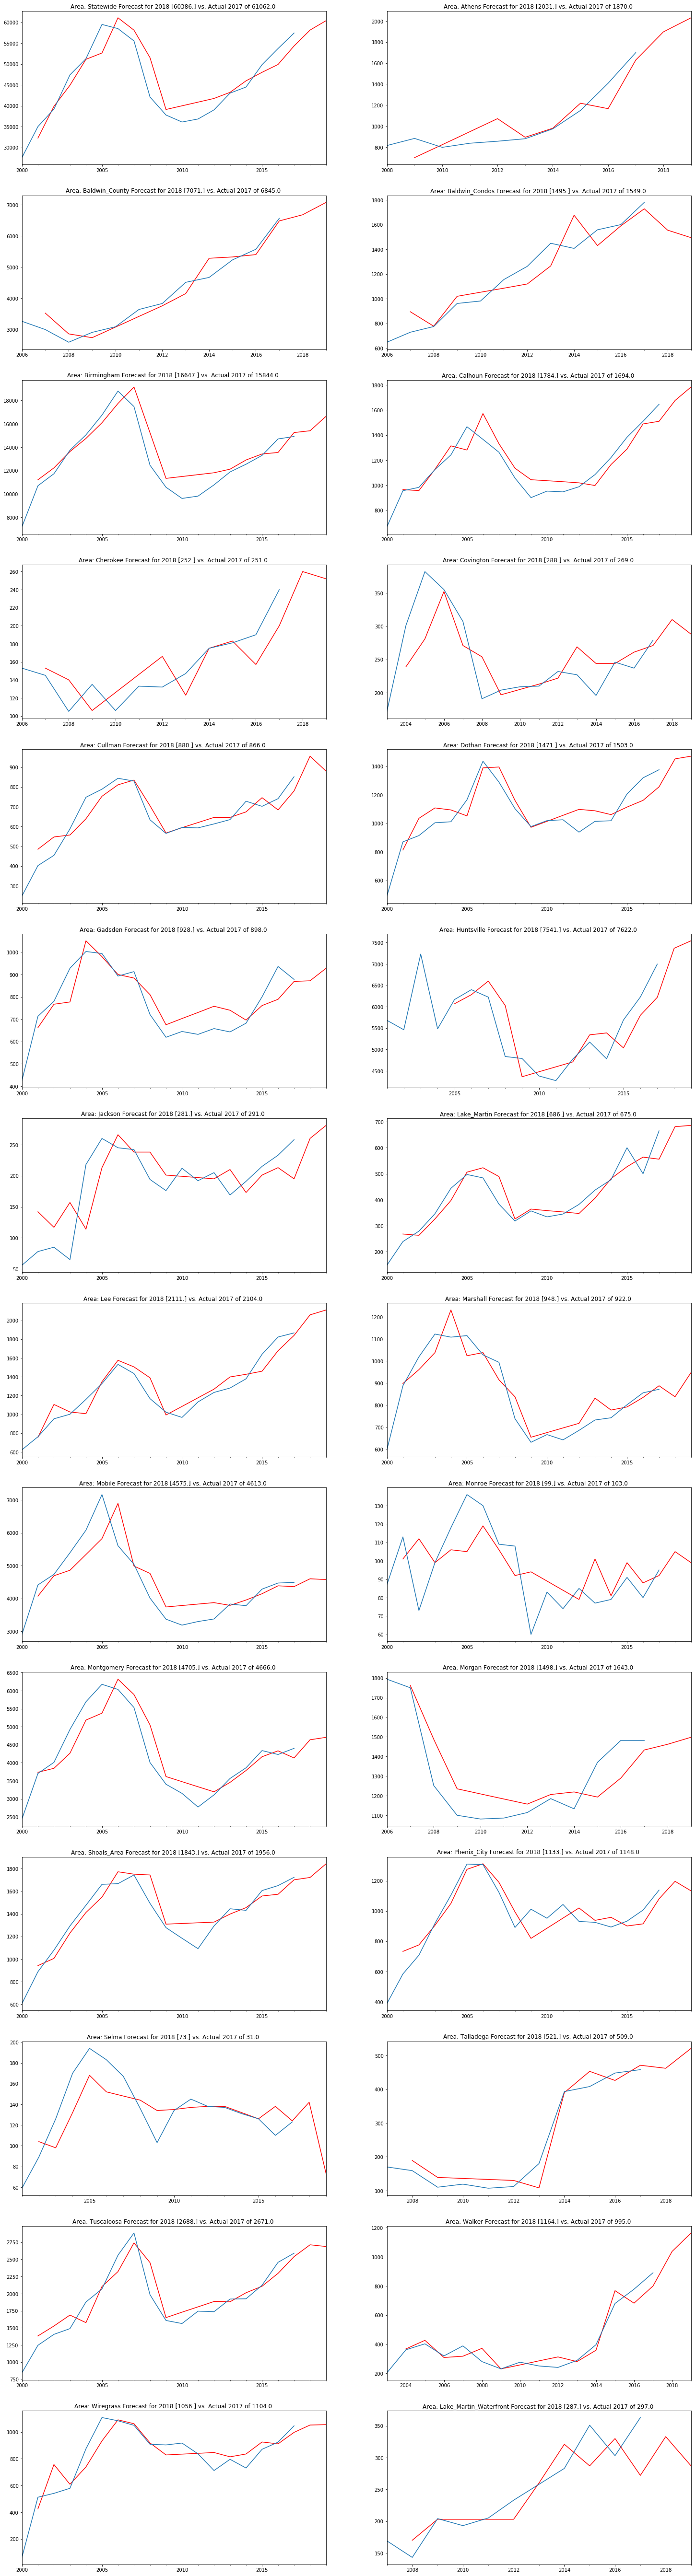

In [68]:
area_tabs=list(map(int, range(1, 29)))
#area_tabs=[1,2,3,4,5,6,7,8,9,10]
nrows = int(math.ceil(len(area_tabs) / 2.))
figlen=nrows*7 #adjust the figure size height to be sized to the number of rows
fig, axs = plt.subplots(nrows, 2, sharey=False, figsize=(25, 7*nrows))
#plt.rcParams['figure.figsize'] = 25,figlen 
#fig, axs = plt.subplots(nrows, 2, sharey=False)
for ax, area_tabs in zip(axs.flat, area_tabs):
    actdf, aname = get_data(area_tabs)
    dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
    merged2.fcast.plot(ax=ax,style='r')
    end = pd.datetime(2018, 1, 31) #Don't include current year actual since this is full year only
    lastyrtot=str(merged2['Units'][-2:-1].iloc[0])
    fullyrs.Units.loc[:end].plot(ax=ax, title='Area: {0} Forecast for 2018 {1} vs. Actual 2017 of {2} '.format(unicode(aname),unicode(merged2['fcast'][-1:].values),
lastyrtot))


For more information contact Tom Brander (tom@oswco.com) or Grayson Glaze (gglaze@cba.ua.edu)

## The cell below produces the monthly breakdown by area

In [13]:
#Get the monthly breakdown for all areas 
area_tabs=list(map(int, range(1, 29)))
for area_tabs in area_tabs:
    actdf,aname = get_data(area_tabs)
    dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
    IPython.display.display('Area mergedfcast: %s' % aname, mergedfcst.tail(12))

/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

'Area mergedfcast: Statewide'

'Area mergedfcast: Athens'

'Area mergedfcast: Baldwin_County'

'Area mergedfcast: Baldwin_Condos'

'Area mergedfcast: Birmingham'

'Area mergedfcast: Calhoun'

'Area mergedfcast: Cherokee'

'Area mergedfcast: Covington'

'Area mergedfcast: Cullman'

'Area mergedfcast: Dothan'

'Area mergedfcast: Gadsden'

'Area mergedfcast: Huntsville'

'Area mergedfcast: Jackson'

'Area mergedfcast: Lake_Martin'

'Area mergedfcast: Lee'

'Area mergedfcast: Marshall'

'Area mergedfcast: Mobile'

'Area mergedfcast: Monroe'

'Area mergedfcast: Montgomery'

'Area mergedfcast: Morgan'

'Area mergedfcast: Shoals_Area'

'Area mergedfcast: Phenix_City'

'Area mergedfcast: Selma'

'Area mergedfcast: Talladega'

'Area mergedfcast: Tuscaloosa'

'Area mergedfcast: Walker'

'Area mergedfcast: Wiregrass'

'Area mergedfcast: Lake_Martin_Waterfront'

#### The section below is used for statistical diagnostics

/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

'Area fcast summary: Statewide'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


'Area regress: Statewide'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     58.66
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.47e-06
Time:                        16:56:24   Log-Likelihood:                -163.28
No. Observations:                  17   AIC:                             330.6
Df Residuals:                      15   BIC:                             332.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.222e+04   4595.889      2.659      0.018    2425.105     2.2e+04
lastqu         3.4477      0.450      7.659      0.000       2.488       4.407
==============================================================================
Omnibus:                        2.559   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                0.852
Skew:                          -0.420   Prob(JB):                        0.653
Kurtosis:                       3.706   Cond. No.                     5.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Statewide'

'Area mergedfcast: Statewide'

Statewide


/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:149: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/tom/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/tom/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


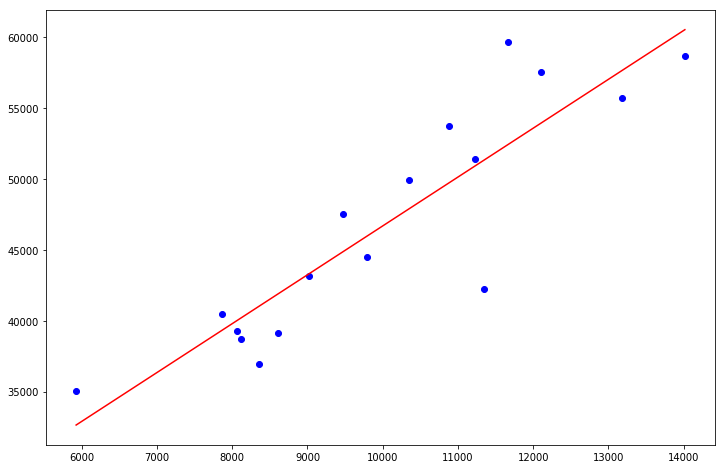

Statewide


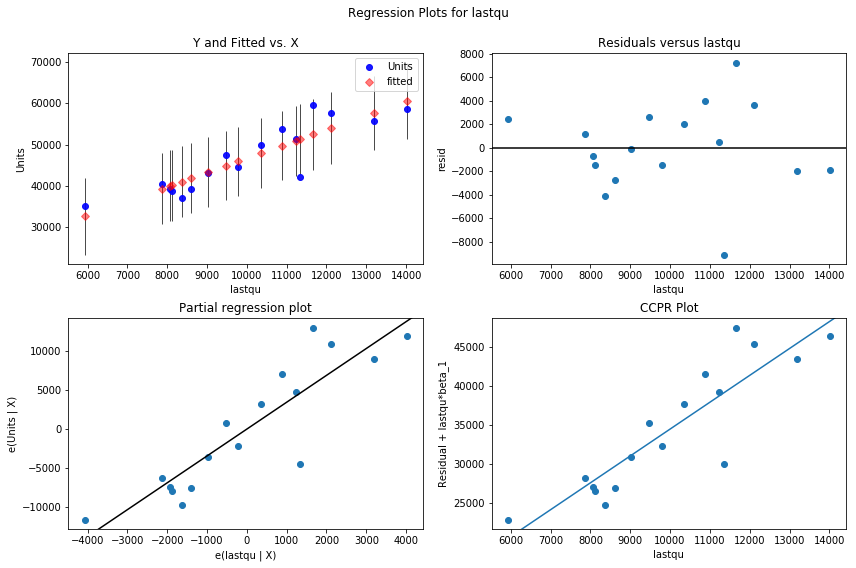

Statewide


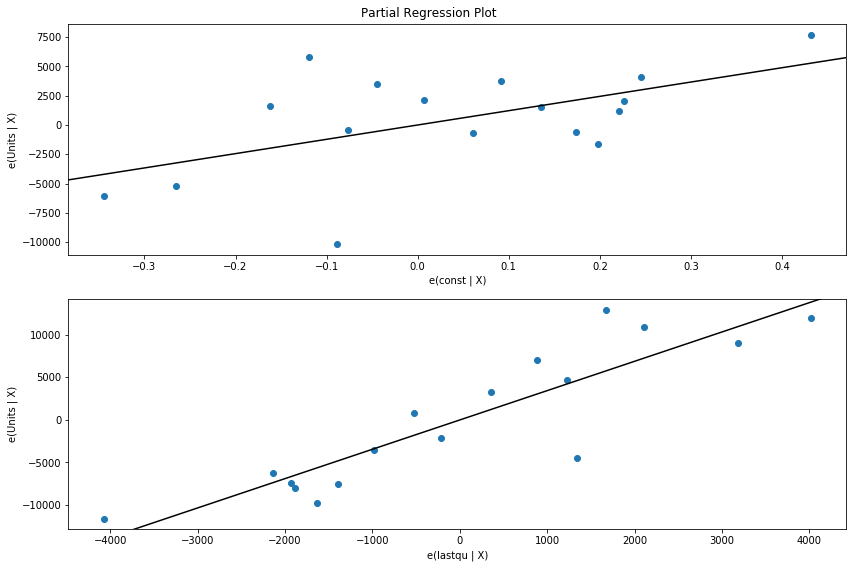

Statewide


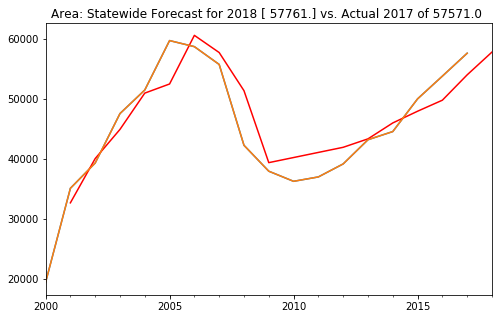

'Area fcast summary: Athens'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


'Area regress: Athens'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     31.60
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           0.000798
Time:                        16:56:28   Log-Likelihood:                -56.243
No. Observations:                   9   AIC:                             116.5
Df Residuals:                       7   BIC:                             116.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8629    186.966      0.181      0.861    -408.241     475.966
lastqu         4.4881      0.798      5.622      0.001       2.600       6.376
==============================================================================
Omnibus:                        0.329   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.096
Skew:                           0.169   Prob(JB):                        0.953
Kurtosis:                       2.625   Cond. No.                         925.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Athens'

'Area mergedfcast: Athens'

Athens


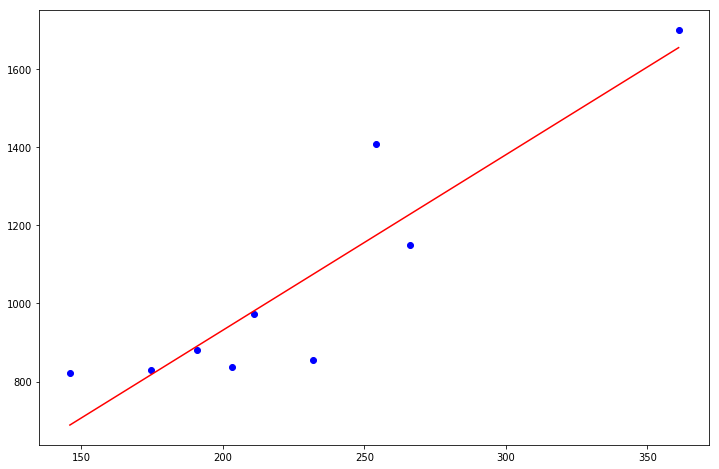

Athens


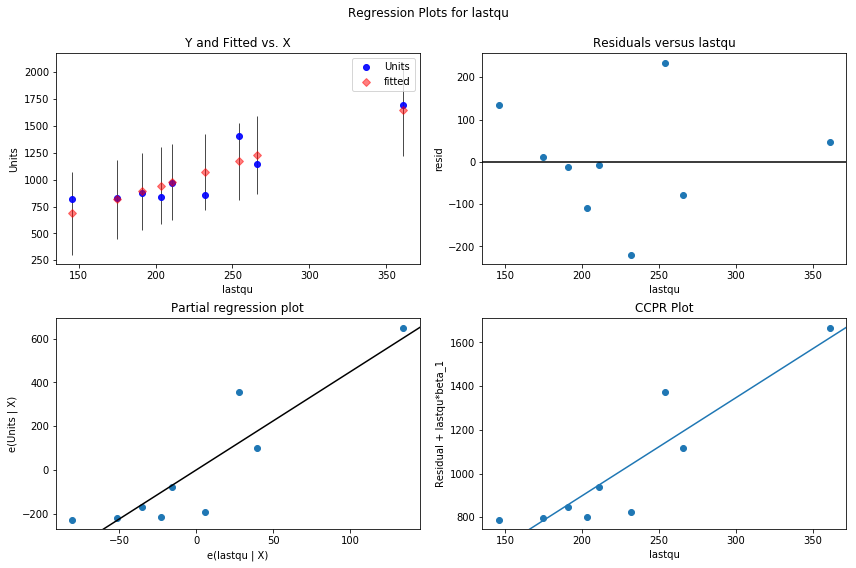

Athens


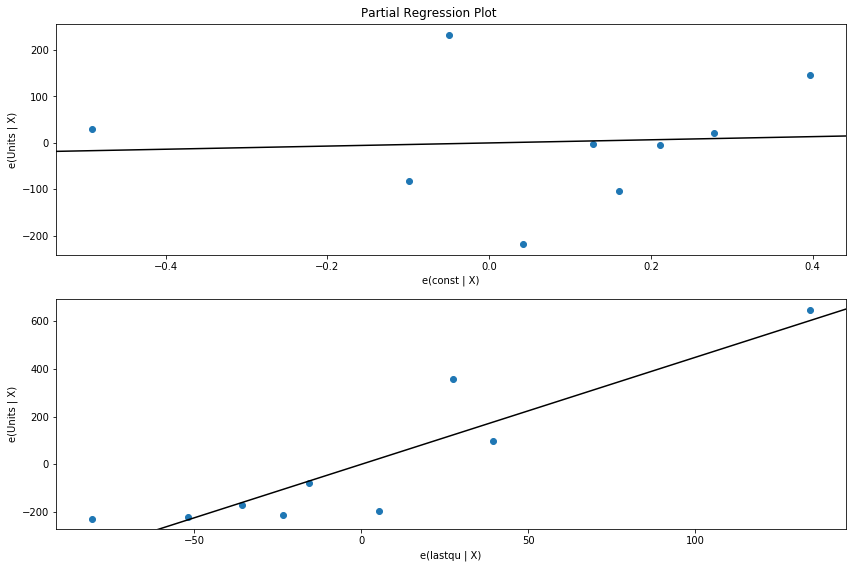

Athens


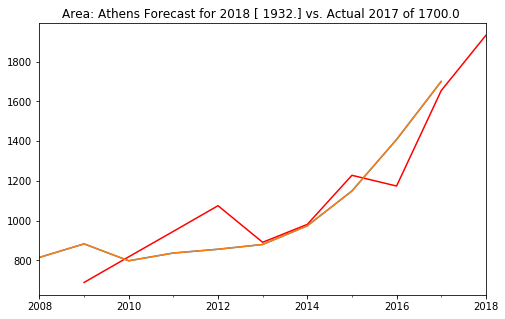

'Area fcast summary: Baldwin_County'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


'Area regress: Baldwin_County'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     128.5
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.25e-06
Time:                        16:56:31   Log-Likelihood:                -78.550
No. Observations:                  11   AIC:                             161.1
Df Residuals:                       9   BIC:                             161.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        185.5010    365.838      0.507      0.624    -642.082    1013.084
lastqu         4.5793      0.404     11.336      0.000       3.665       5.493
==============================================================================
Omnibus:                        2.251   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.536
Skew:                          -0.836   Prob(JB):                        0.464
Kurtosis:                       2.255   Cond. No.                     3.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Baldwin_County'

'Area mergedfcast: Baldwin_County'

Baldwin_County


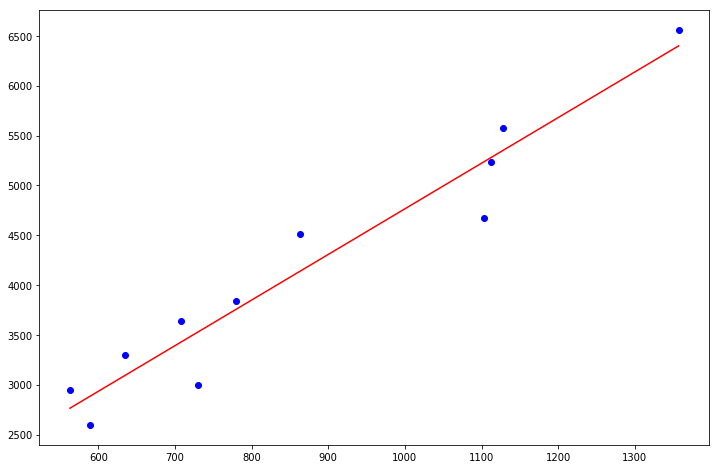

Baldwin_County


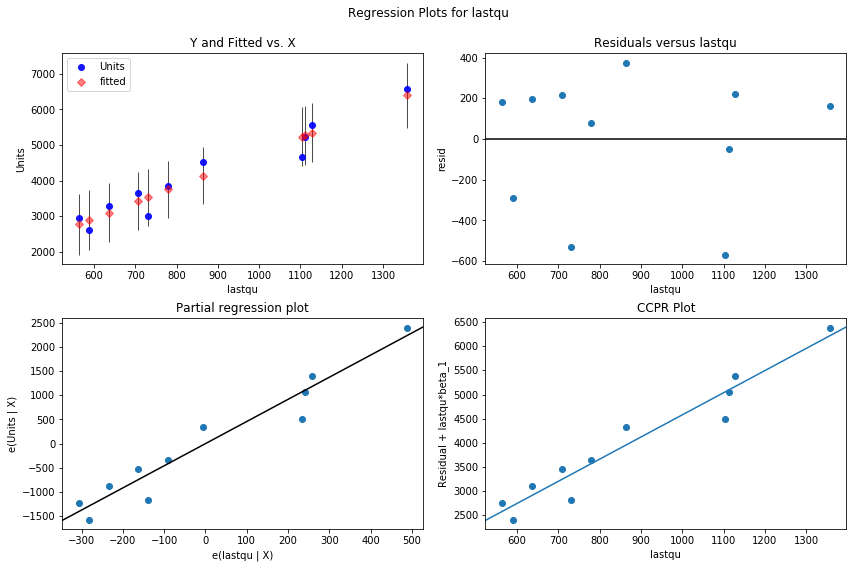

Baldwin_County


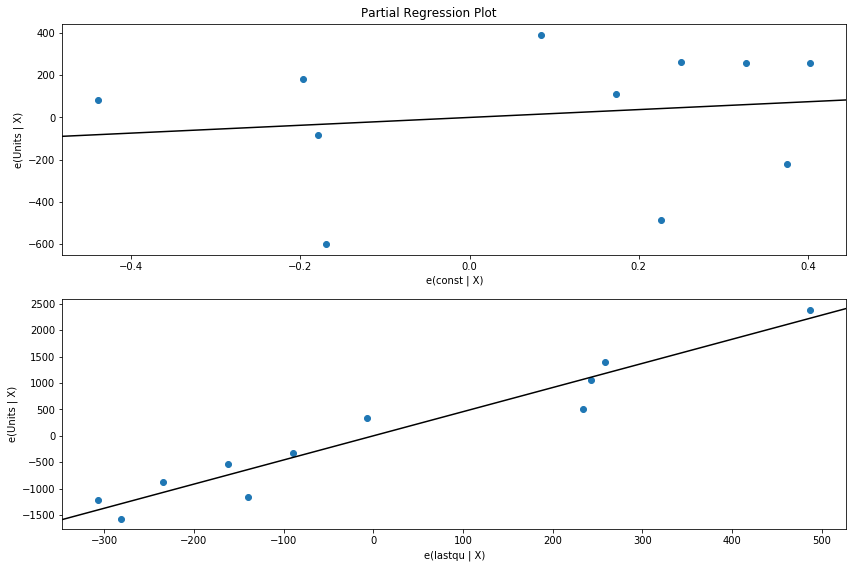

Baldwin_County


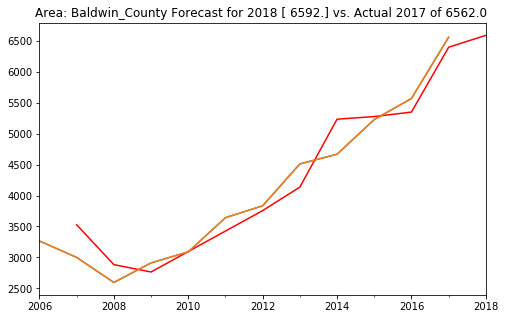

'Area fcast summary: Baldwin_Condos'

'Area regress: Baldwin_Condos'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     48.92
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           6.37e-05
Time:                        16:56:33   Log-Likelihood:                -69.352
No. Observations:                  11   AIC:                             142.7
Df Residuals:                       9   BIC:                             143.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         97.9857    169.306      0.579      0.577    -285.011     480.982
lastqu         4.3303      0.619      6.994      0.000       2.930       5.731
==============================================================================
Omnibus:                        1.062   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                0.749
Skew:                          -0.567   Prob(JB):                        0.688
Kurtosis:                       2.408   Cond. No.                     1.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Baldwin_Condos'

'Area mergedfcast: Baldwin_Condos'

Baldwin_Condos


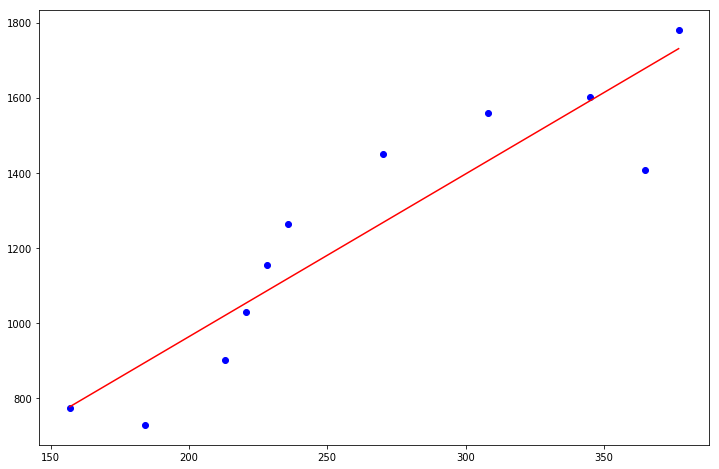

Baldwin_Condos


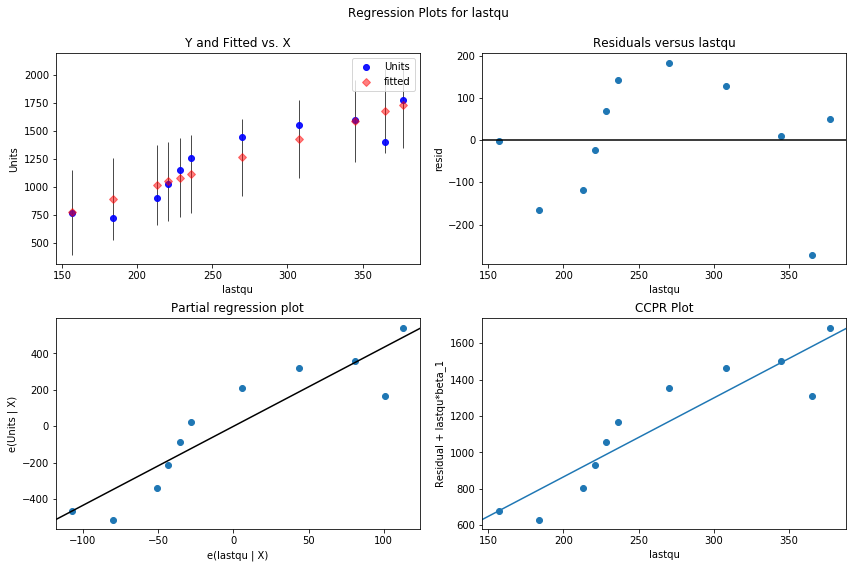

Baldwin_Condos


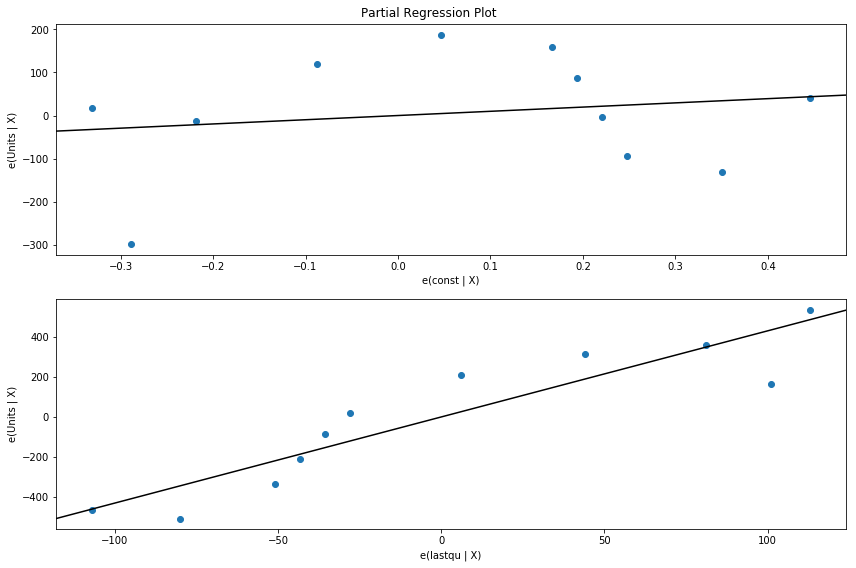

Baldwin_Condos


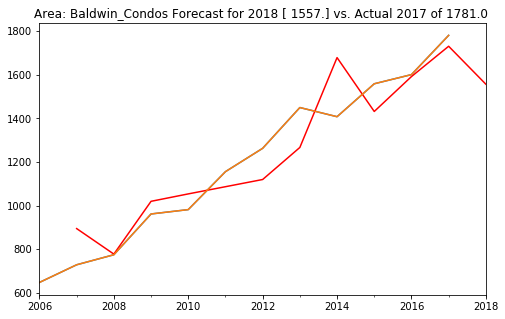

'Area fcast summary: Birmingham'

'Area regress: Birmingham'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     77.72
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           2.55e-07
Time:                        16:56:36   Log-Likelihood:                -141.37
No. Observations:                  17   AIC:                             286.7
Df Residuals:                      15   BIC:                             288.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3105.7368   1229.693      2.526      0.023     484.708    5726.766
lastqu         3.6880      0.418      8.816      0.000       2.796       4.580
==============================================================================
Omnibus:                        1.082   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                0.230
Skew:                           0.266   Prob(JB):                        0.891
Kurtosis:                       3.204   Cond. No.                     1.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Birmingham'

'Area mergedfcast: Birmingham'

Birmingham


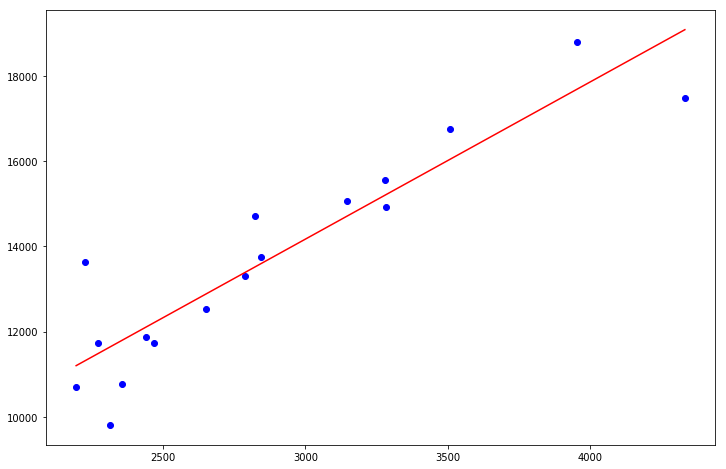

Birmingham


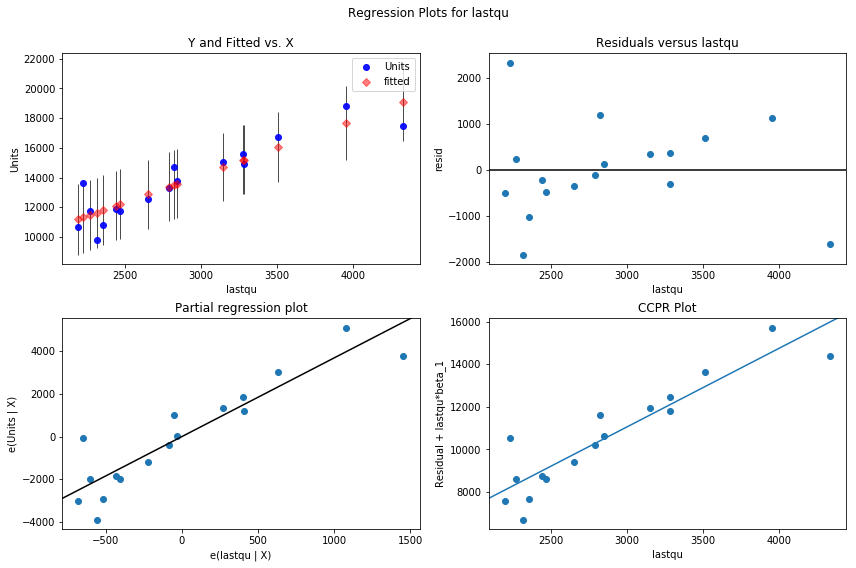

Birmingham


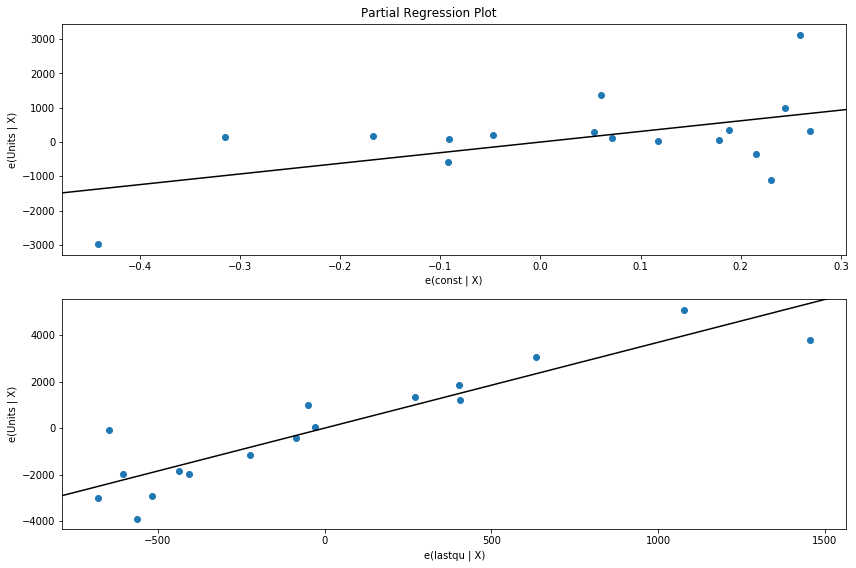

Birmingham


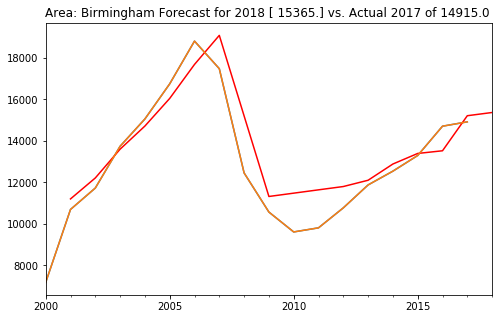

'Area fcast summary: Calhoun'

'Area regress: Calhoun'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     65.42
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           7.52e-07
Time:                        16:56:40   Log-Likelihood:                -100.93
No. Observations:                  17   AIC:                             205.9
Df Residuals:                      15   BIC:                             207.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.5667    135.145      0.848      0.410    -173.488     402.621
lastqu         4.0993      0.507      8.088      0.000       3.019       5.180
==============================================================================
Omnibus:                        0.394   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.036
Skew:                           0.109   Prob(JB):                        0.982
Kurtosis:                       2.941   Cond. No.                     1.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Calhoun'

'Area mergedfcast: Calhoun'

Calhoun


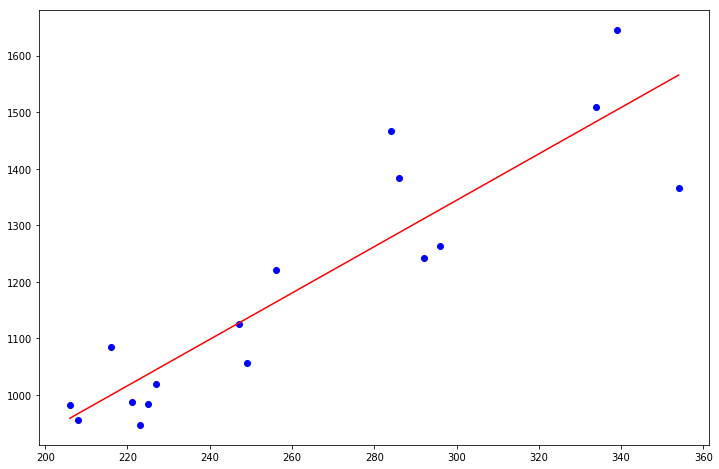

Calhoun


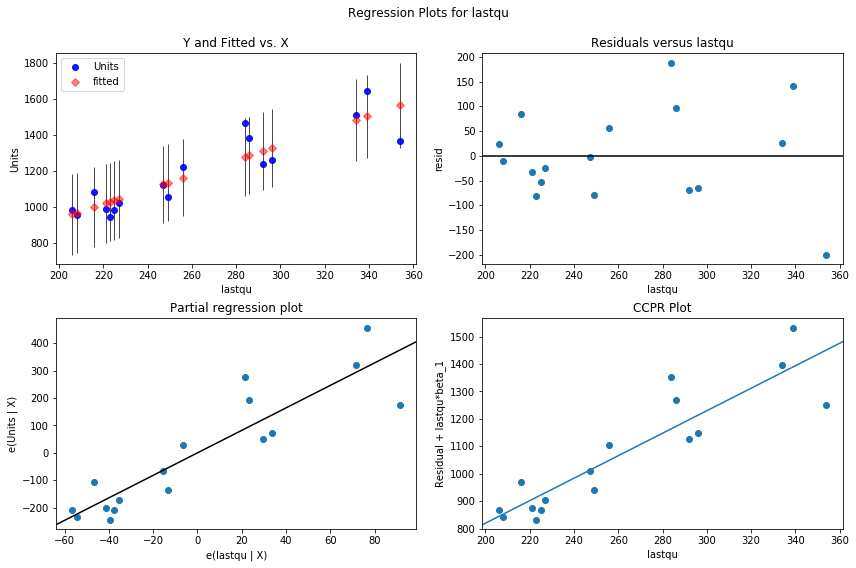

Calhoun


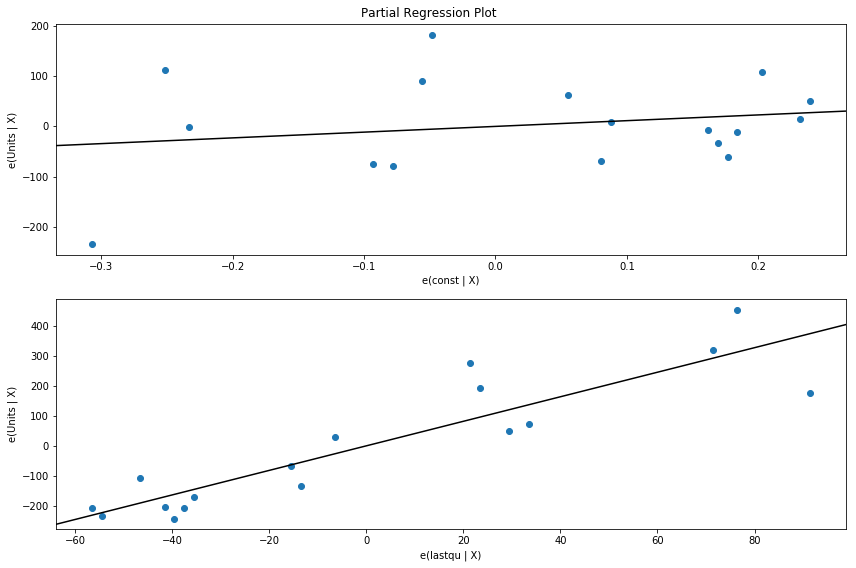

Calhoun


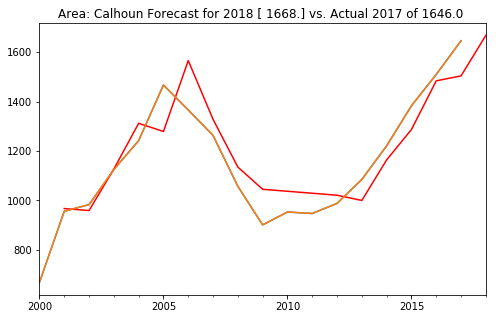

'Area fcast summary: Cherokee'

'Area regress: Cherokee'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     16.40
Date:                Mon, 29 Jan 2018   Prob (F-statistic):            0.00289
Time:                        16:56:43   Log-Likelihood:                -50.456
No. Observations:                  11   AIC:                             104.9
Df Residuals:                       9   BIC:                             105.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8414     38.743     -0.073      0.943     -90.485      84.802
lastqu         5.1502      1.272      4.049      0.003       2.273       8.027
==============================================================================
Omnibus:                        1.461   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                0.762
Skew:                           0.095   Prob(JB):                        0.683
Kurtosis:                       1.725   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Cherokee'

'Area mergedfcast: Cherokee'

Cherokee


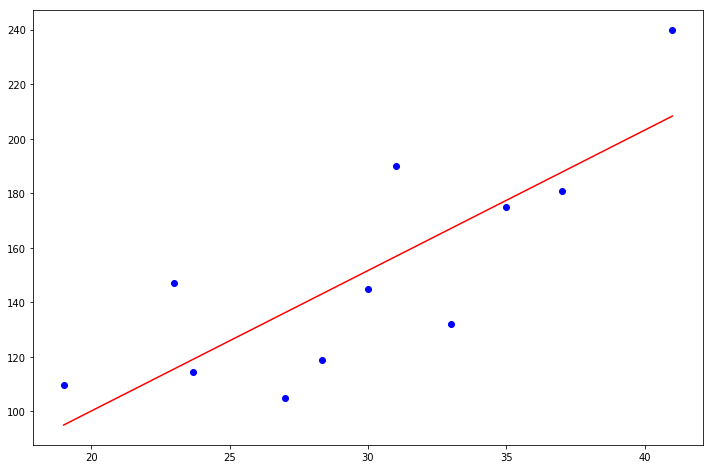

Cherokee


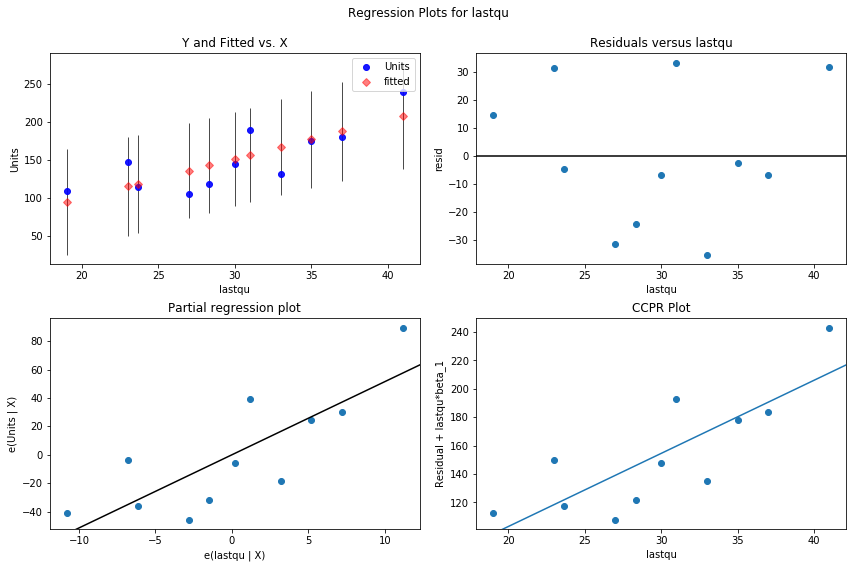

Cherokee


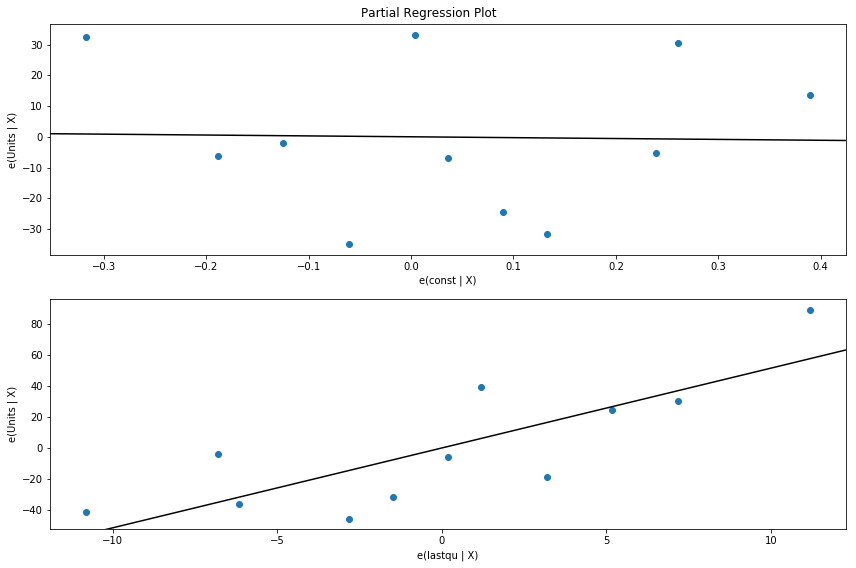

Cherokee


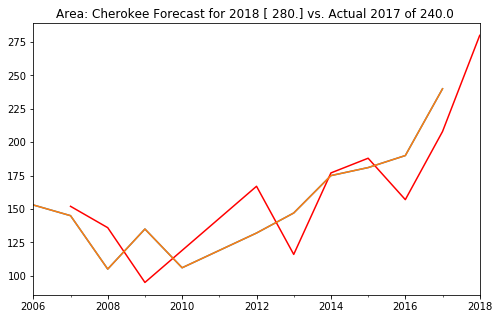

'Area fcast summary: Covington'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


'Area regress: Covington'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     12.73
Date:                Mon, 29 Jan 2018   Prob (F-statistic):            0.00387
Time:                        16:56:46   Log-Likelihood:                -71.899
No. Observations:                  14   AIC:                             147.8
Df Residuals:                      12   BIC:                             149.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.2719     45.932      2.096      0.058      -3.806     196.350
lastqu         2.7702      0.776      3.568      0.004       1.078       4.462
==============================================================================
Omnibus:                        1.976   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                0.789
Skew:                           0.578   Prob(JB):                        0.674
Kurtosis:                       3.119   Cond. No.                         229.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Covington'

'Area mergedfcast: Covington'

Covington


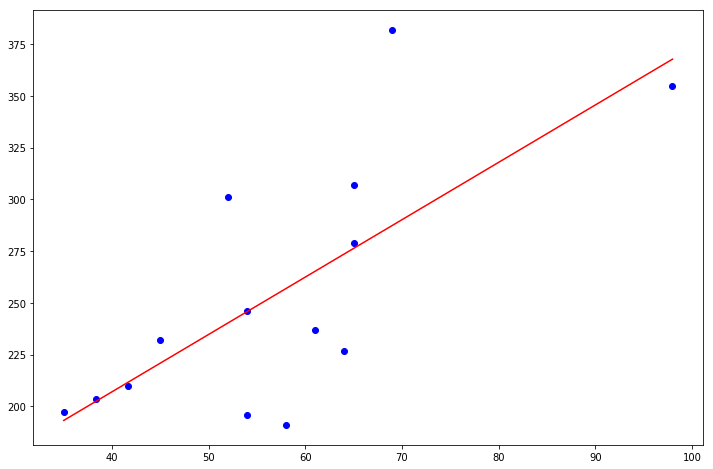

Covington


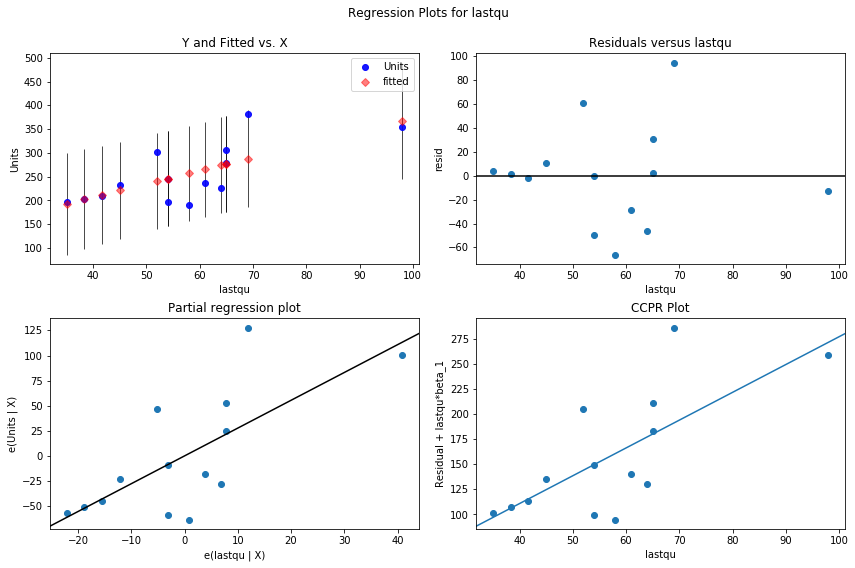

Covington


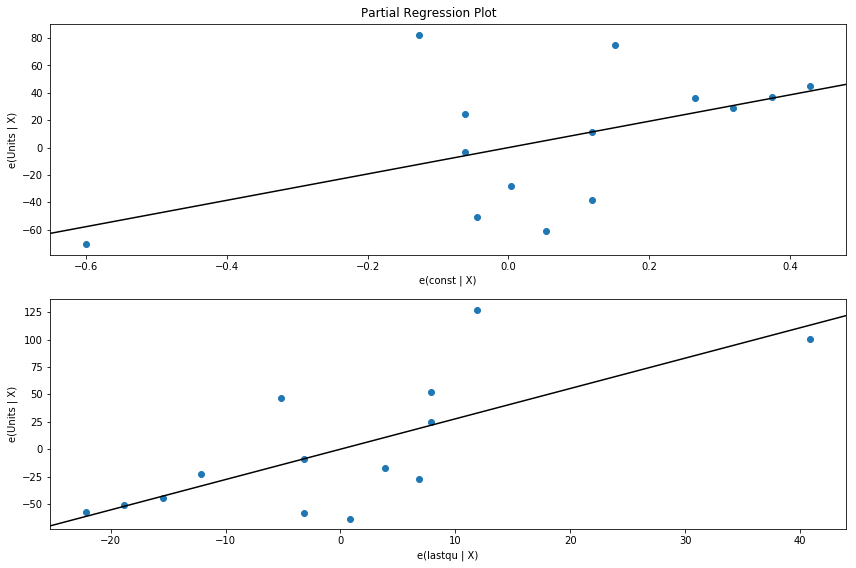

Covington


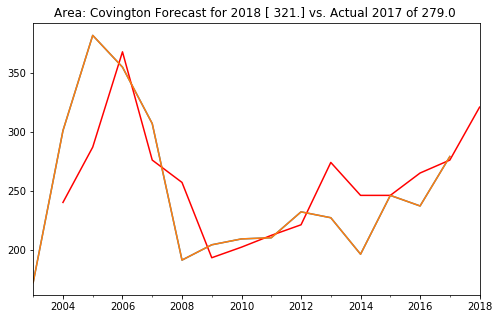

'Area fcast summary: Cullman'

'Area regress: Cullman'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     65.40
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           7.53e-07
Time:                        16:56:47   Log-Likelihood:                -91.816
No. Observations:                  17   AIC:                             187.6
Df Residuals:                      15   BIC:                             189.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.6208     70.469      1.570      0.137     -39.580     260.822
lastqu         4.0150      0.496      8.087      0.000       2.957       5.073
==============================================================================
Omnibus:                        0.876   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.645   Jarque-Bera (JB):                0.707
Skew:                           0.114   Prob(JB):                        0.702
Kurtosis:                       2.028   Cond. No.                         722.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Cullman'

'Area mergedfcast: Cullman'

Cullman


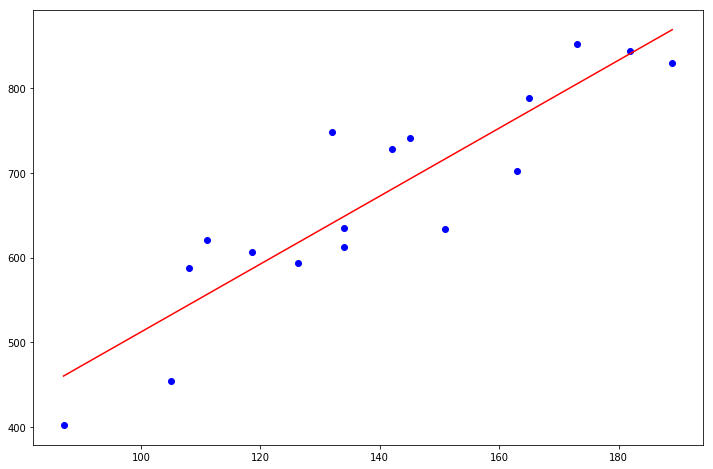

Cullman


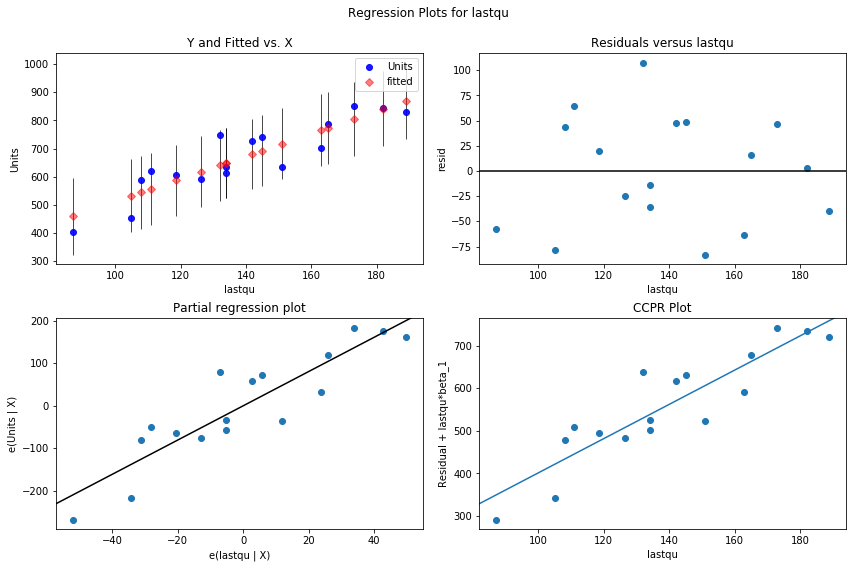

Cullman


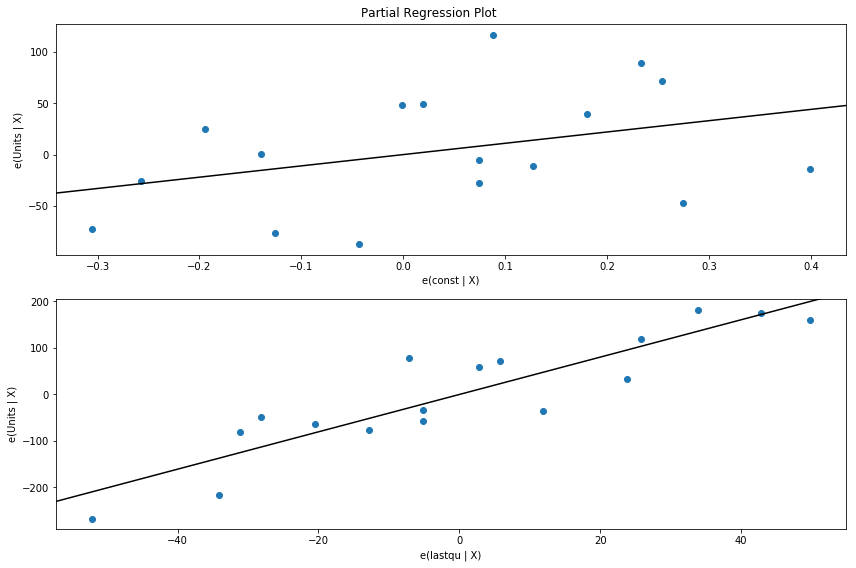

Cullman


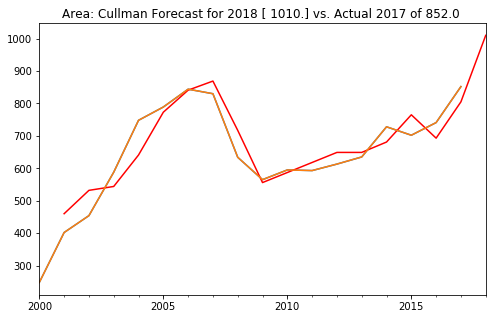

'Area fcast summary: Dothan'

'Area regress: Dothan'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     26.83
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           0.000112
Time:                        16:56:50   Log-Likelihood:                -101.79
No. Observations:                  17   AIC:                             207.6
Df Residuals:                      15   BIC:                             209.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        361.6196    146.007      2.477      0.026      50.413     672.826
lastqu         3.1226      0.603      5.180      0.000       1.838       4.408
==============================================================================
Omnibus:                        3.476   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                1.275
Skew:                           0.119   Prob(JB):                        0.529
Kurtosis:                       1.679   Cond. No.                     1.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Dothan'

'Area mergedfcast: Dothan'

Dothan


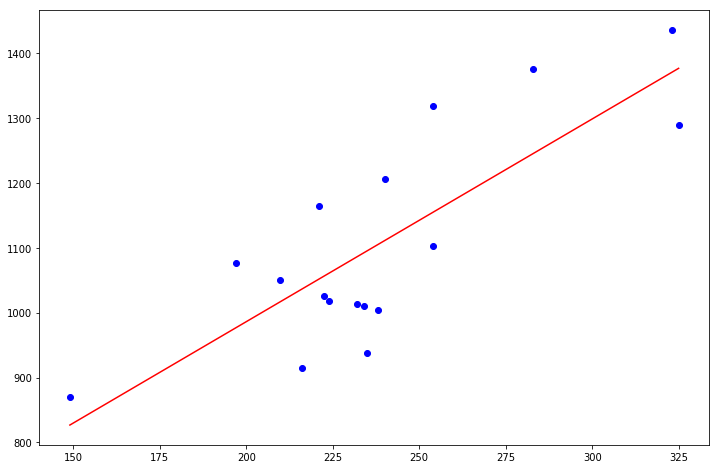

Dothan


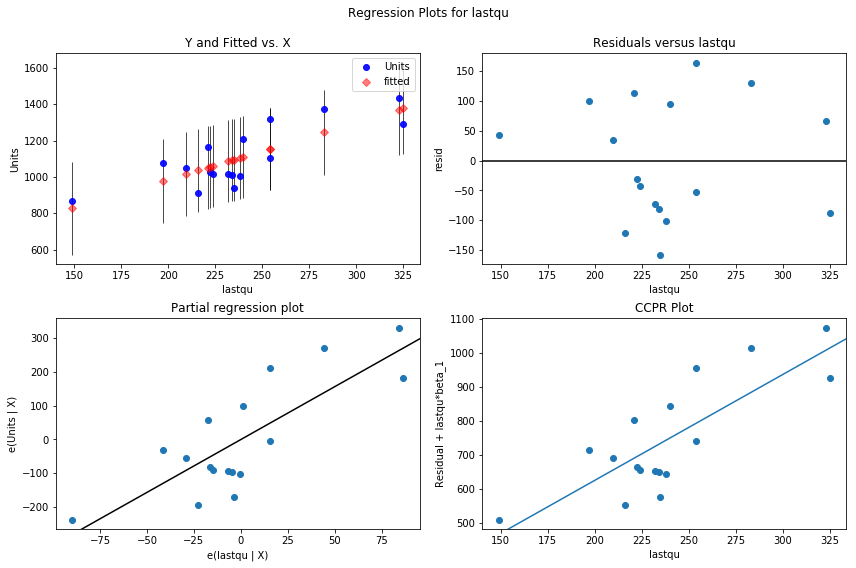

Dothan


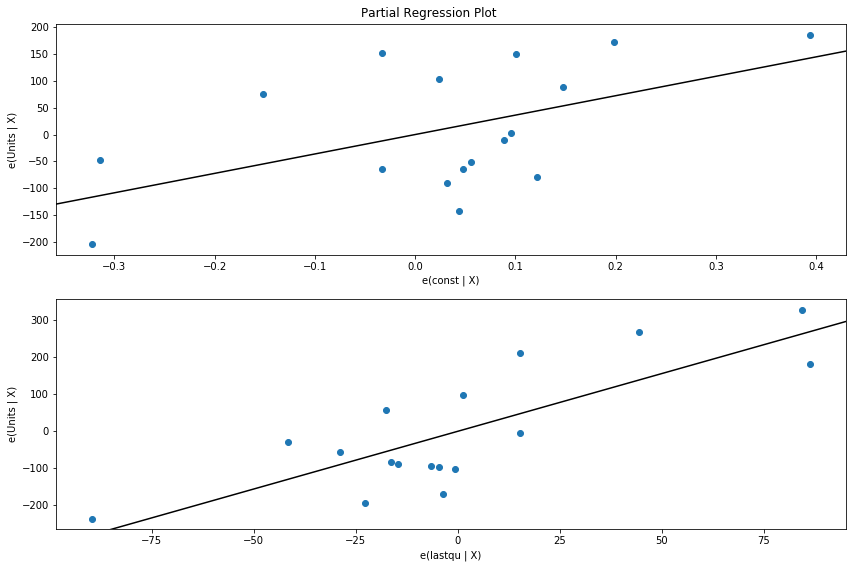

Dothan


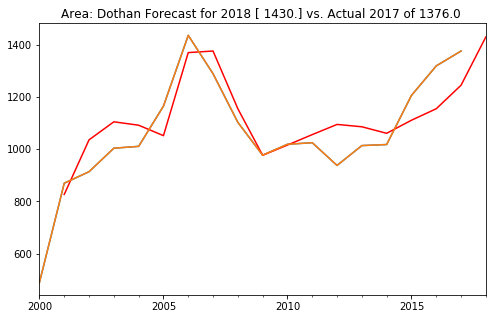

'Area fcast summary: Gadsden'

'Area regress: Gadsden'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     30.03
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           6.34e-05
Time:                        16:56:54   Log-Likelihood:                -97.194
No. Observations:                  17   AIC:                             198.4
Df Residuals:                      15   BIC:                             200.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        287.6947     94.817      3.034      0.008      85.598     489.791
lastqu         3.0721      0.561      5.480      0.000       1.877       4.267
==============================================================================
Omnibus:                        1.106   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.575   Jarque-Bera (JB):                0.703
Skew:                           0.481   Prob(JB):                        0.703
Kurtosis:                       2.736   Cond. No.                         844.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Gadsden'

'Area mergedfcast: Gadsden'

Gadsden


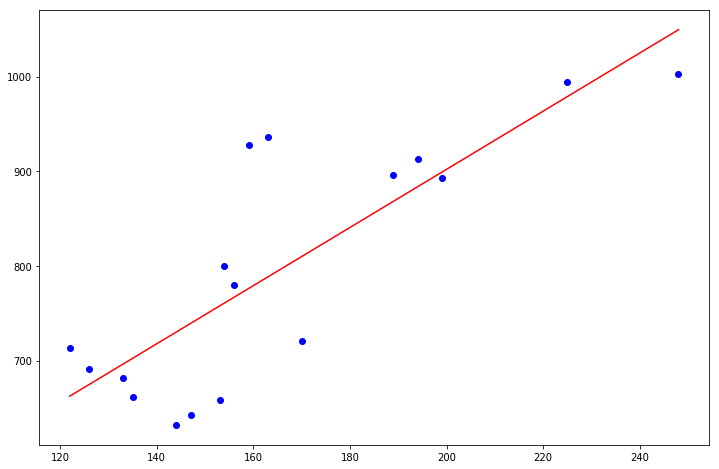

Gadsden


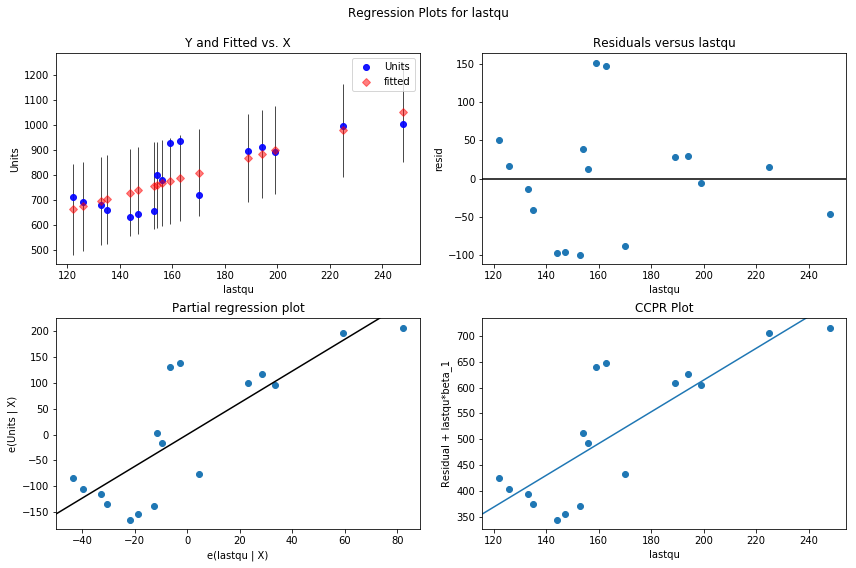

Gadsden


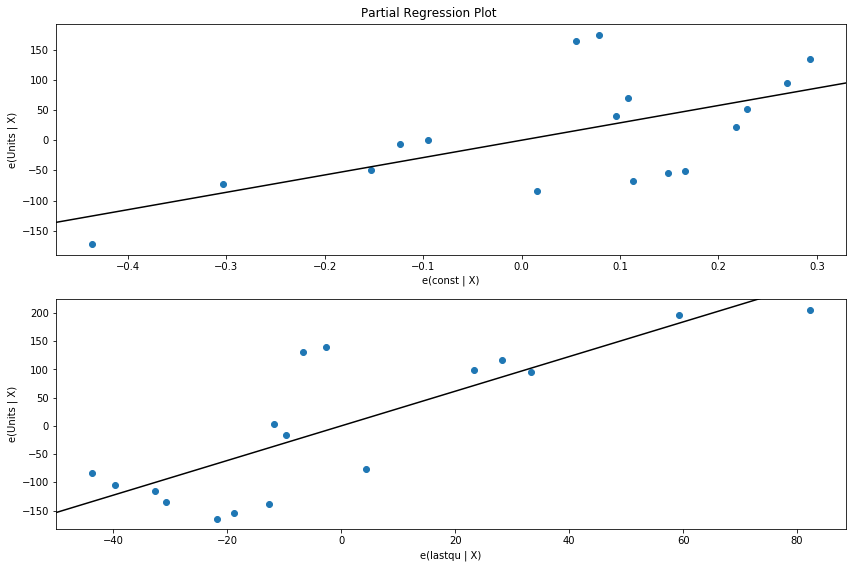

Gadsden


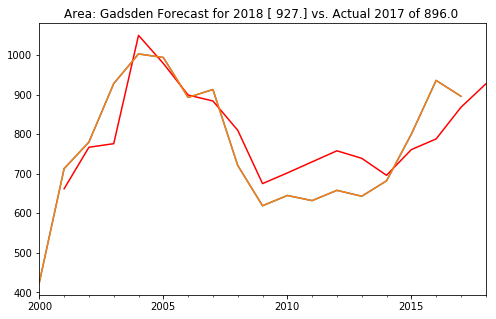

'Area fcast summary: Huntsville'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


'Area regress: Huntsville'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     20.02
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           0.000940
Time:                        16:56:58   Log-Likelihood:                -99.418
No. Observations:                  13   AIC:                             202.8
Df Residuals:                      11   BIC:                             204.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        826.1966   1041.296      0.793      0.444   -1465.681    3118.075
lastqu         3.7946      0.848      4.474      0.001       1.928       5.661
==============================================================================
Omnibus:                        1.137   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.392
Skew:                          -0.424   Prob(JB):                        0.822
Kurtosis:                       2.949   Cond. No.                     8.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Huntsville'

'Area mergedfcast: Huntsville'

Huntsville


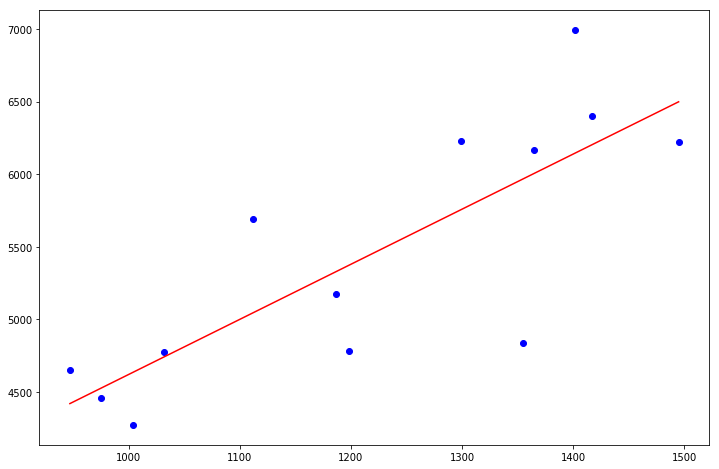

Huntsville


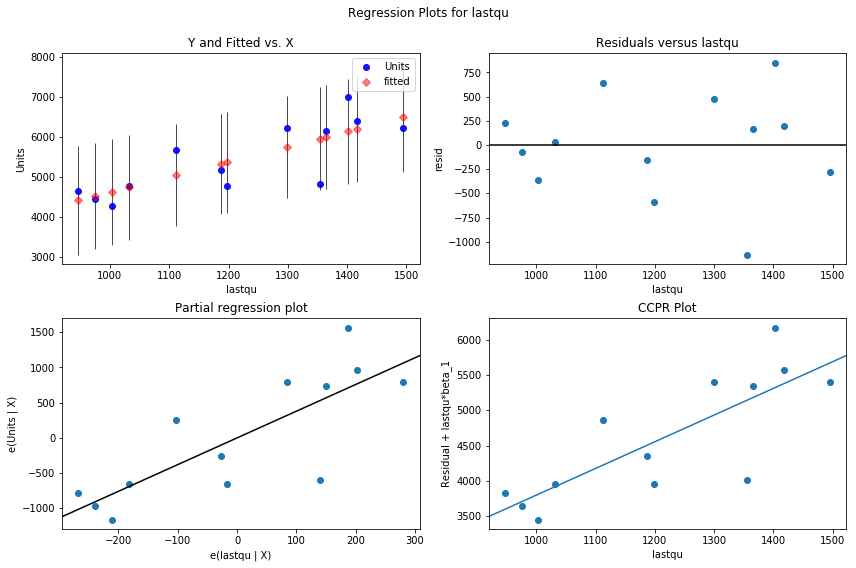

Huntsville


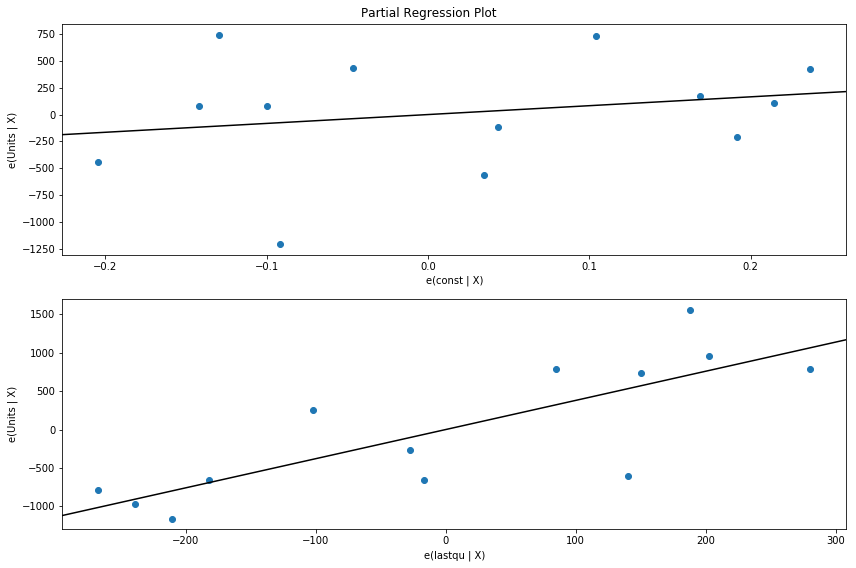

Huntsville


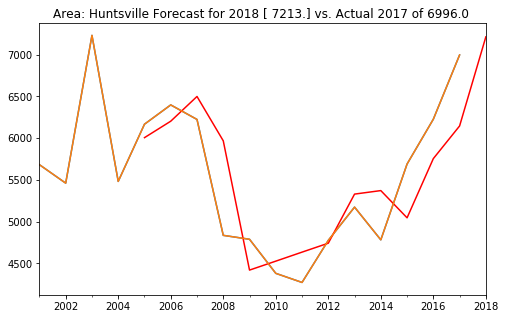

'Area fcast summary: Jackson'

'Area regress: Jackson'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     9.566
Date:                Mon, 29 Jan 2018   Prob (F-statistic):            0.00742
Time:                        16:57:02   Log-Likelihood:                -89.136
No. Observations:                  17   AIC:                             182.3
Df Residuals:                      15   BIC:                             183.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.7040     38.908      1.946      0.071      -7.227     158.635
lastqu         2.8495      0.921      3.093      0.007       0.886       4.813
==============================================================================
Omnibus:                        0.470   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.027
Skew:                           0.097   Prob(JB):                        0.987
Kurtosis:                       3.001   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Jackson'

'Area mergedfcast: Jackson'

Jackson


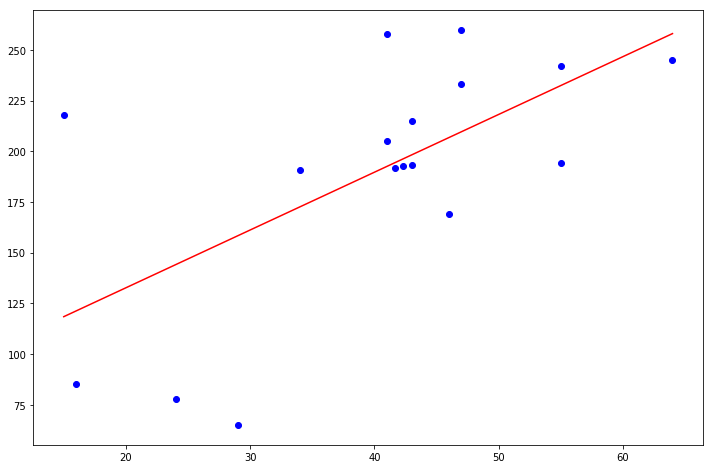

Jackson


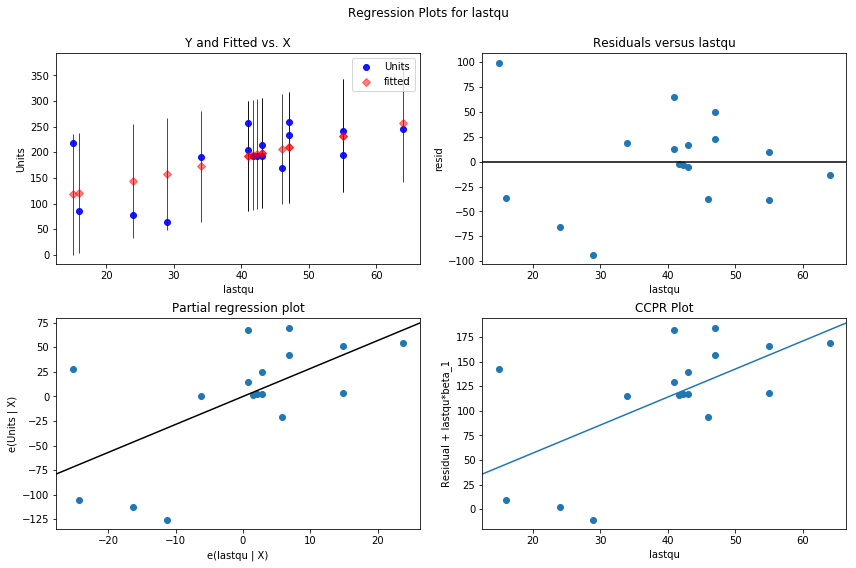

Jackson


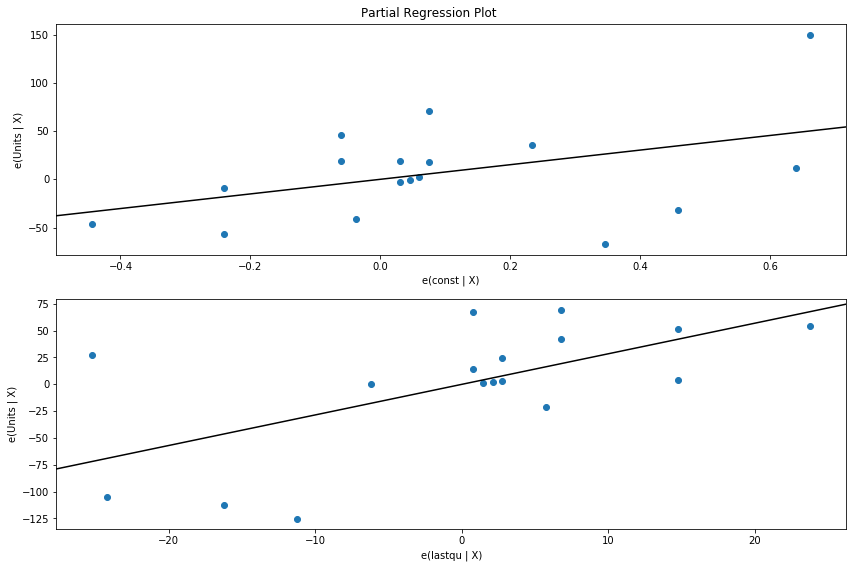

Jackson


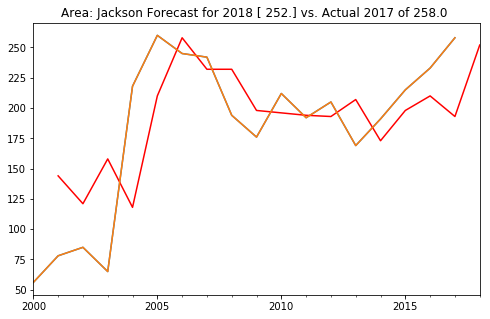

'Area fcast summary: Lake_Martin'

'Area regress: Lake_Martin'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     58.24
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.53e-06
Time:                        16:57:07   Log-Likelihood:                -90.533
No. Observations:                  17   AIC:                             185.1
Df Residuals:                      15   BIC:                             186.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.8856     46.788      1.536      0.145     -27.841     171.612
lastqu         4.2266      0.554      7.631      0.000       3.046       5.407
==============================================================================
Omnibus:                        0.602   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.015
Skew:                           0.052   Prob(JB):                        0.992
Kurtosis:                       3.102   Cond. No.                         308.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Lake_Martin'

'Area mergedfcast: Lake_Martin'

Lake_Martin


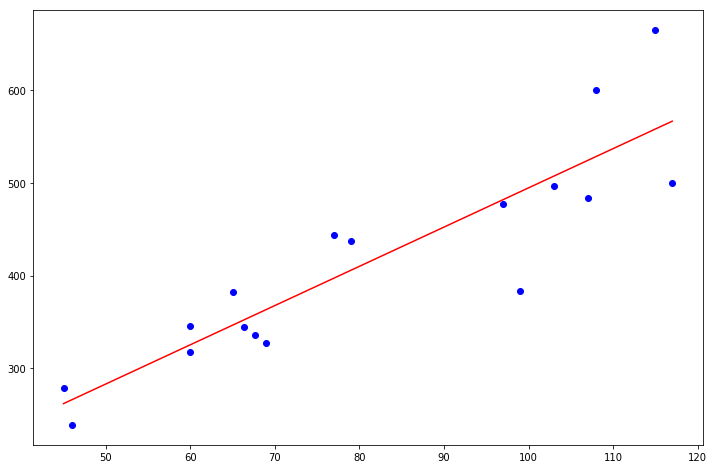

Lake_Martin


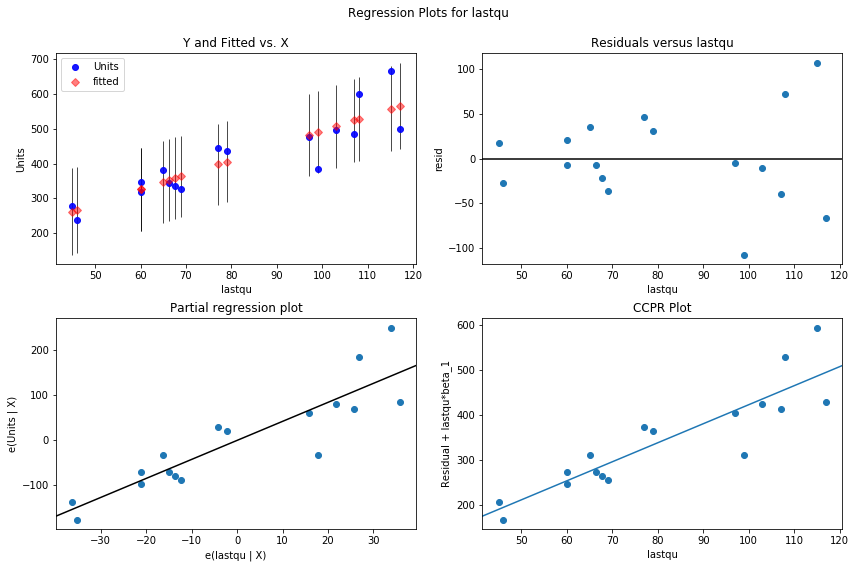

Lake_Martin


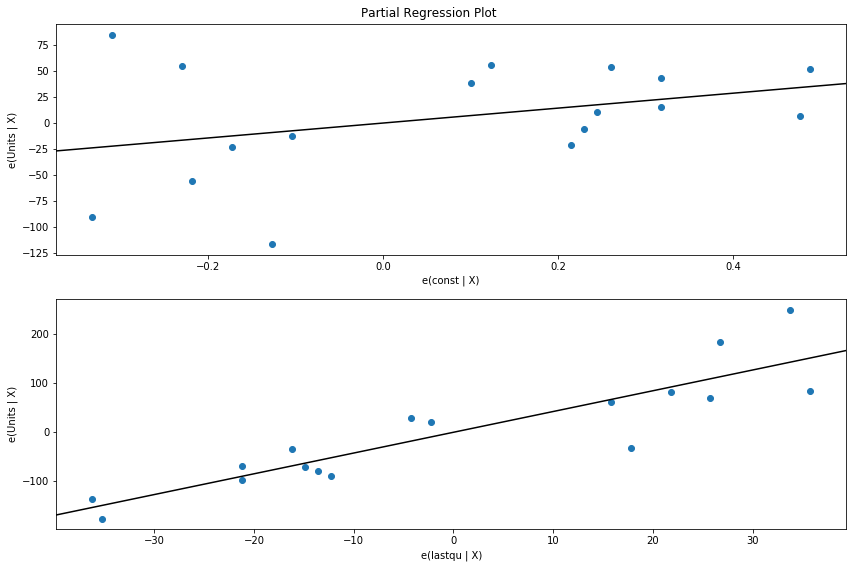

Lake_Martin


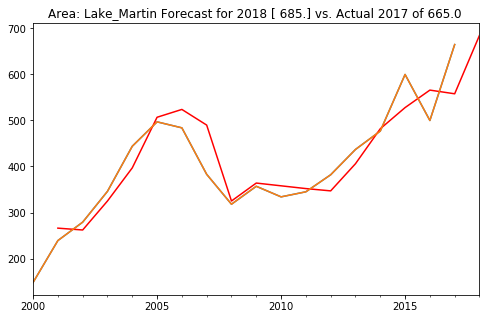

'Area fcast summary: Lee'

'Area regress: Lee'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     87.19
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.22e-07
Time:                        16:57:12   Log-Likelihood:                -104.05
No. Observations:                  17   AIC:                             212.1
Df Residuals:                      15   BIC:                             213.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        264.2737    113.803      2.322      0.035      21.709     506.838
lastqu         4.5314      0.485      9.337      0.000       3.497       5.566
==============================================================================
Omnibus:                        0.093   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.955   Jarque-Bera (JB):                0.308
Skew:                           0.091   Prob(JB):                        0.857
Kurtosis:                       2.366   Cond. No.                         938.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Lee'

'Area mergedfcast: Lee'

Lee


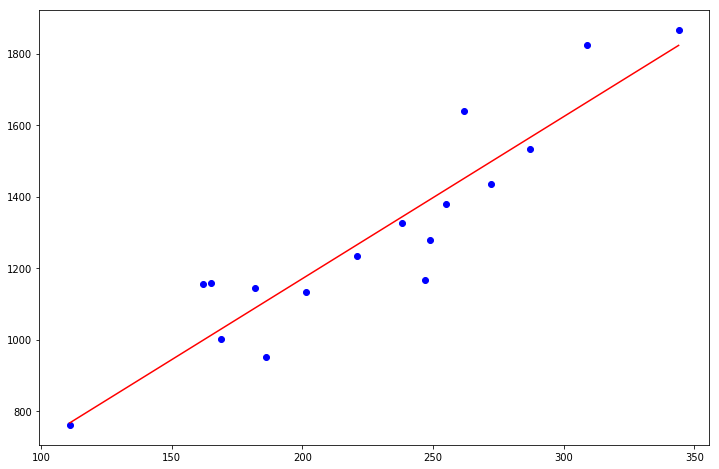

Lee


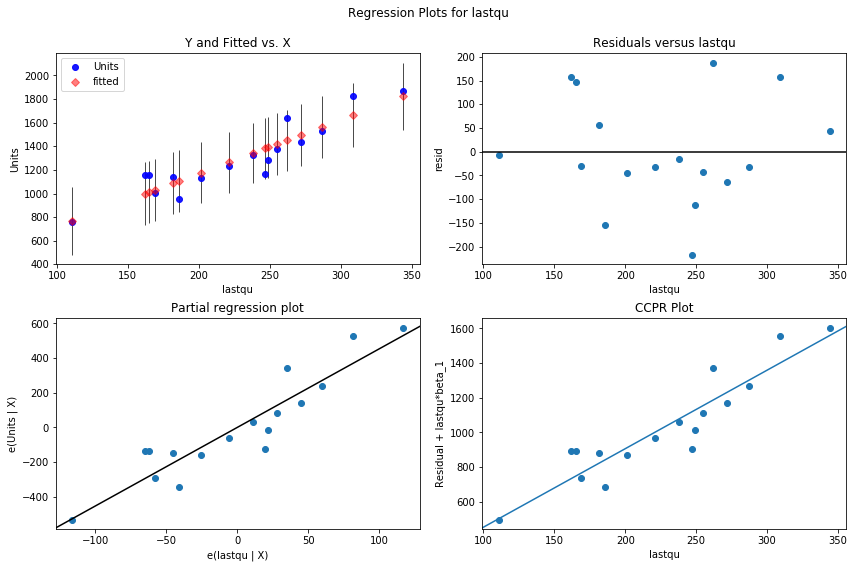

Lee


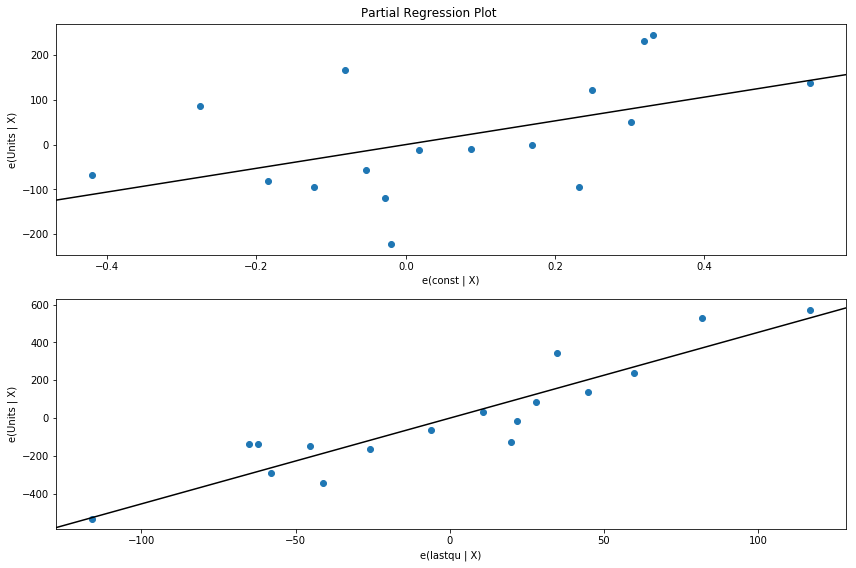

Lee


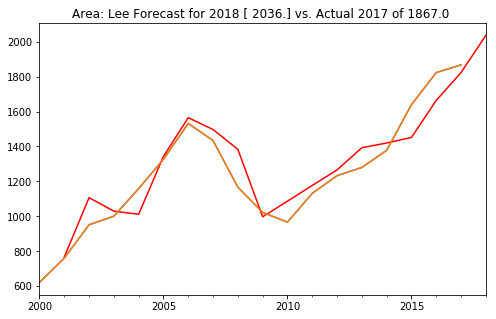

'Area fcast summary: Marshall'

'Area regress: Marshall'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     84.16
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.53e-07
Time:                        16:57:16   Log-Likelihood:                -94.624
No. Observations:                  17   AIC:                             193.2
Df Residuals:                      15   BIC:                             194.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.8659     74.475      2.684      0.017      41.126     358.606
lastqu         3.3498      0.365      9.174      0.000       2.572       4.128
==============================================================================
Omnibus:                        0.628   Durbin-Watson:                   2.734
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.651
Skew:                          -0.223   Prob(JB):                        0.722
Kurtosis:                       2.152   Cond. No.                         930.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Marshall'

'Area mergedfcast: Marshall'

Marshall


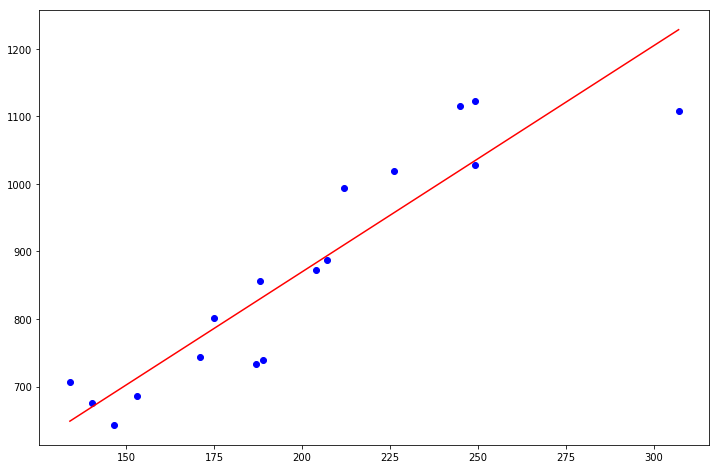

Marshall


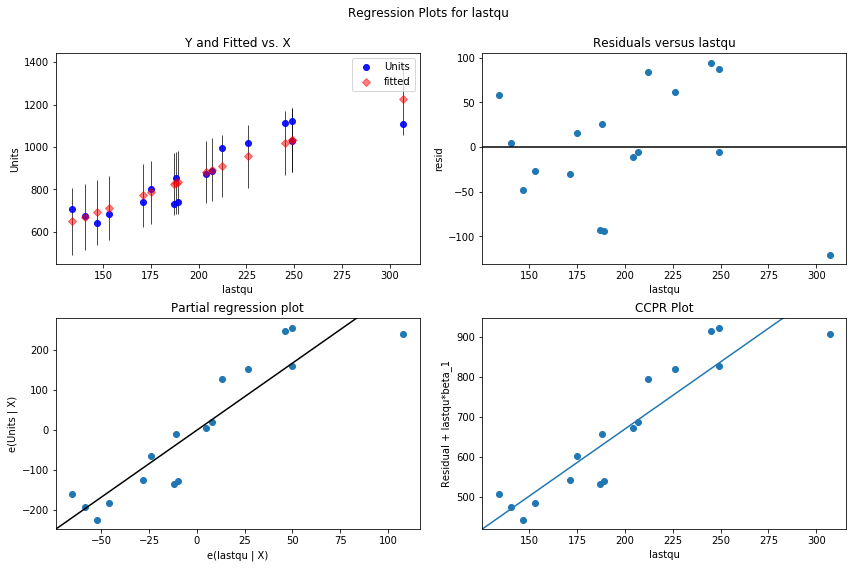

Marshall


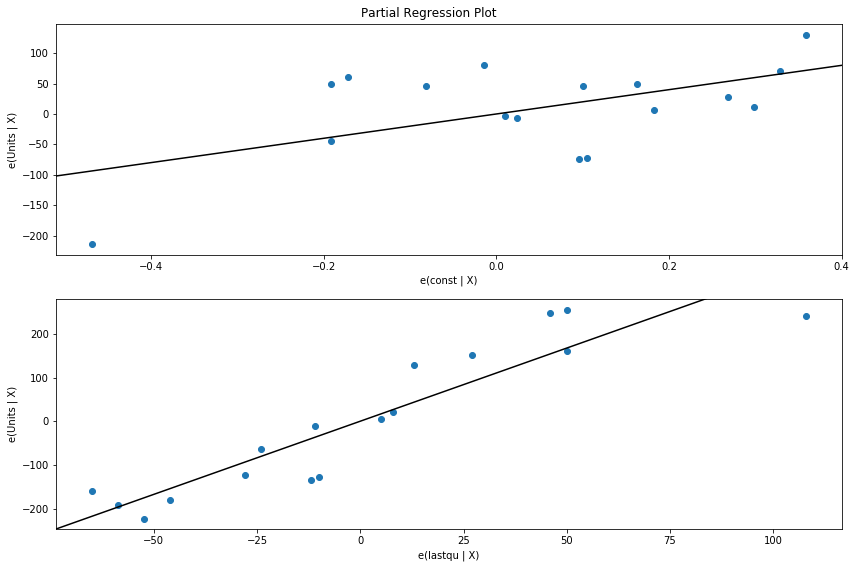

Marshall


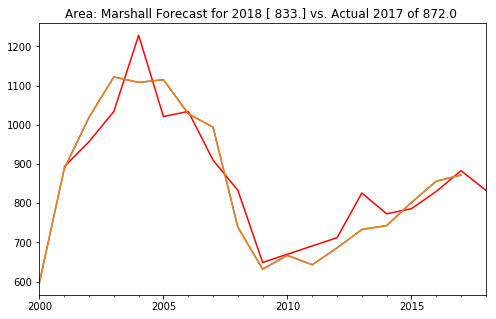

'Area fcast summary: Mobile'

'Area regress: Mobile'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     31.10
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           5.29e-05
Time:                        16:57:18   Log-Likelihood:                -132.20
No. Observations:                  17   AIC:                             268.4
Df Residuals:                      15   BIC:                             270.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1509.3333    564.415      2.674      0.017     306.311    2712.355
lastqu         2.9818      0.535      5.577      0.000       1.842       4.121
==============================================================================
Omnibus:                        1.690   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                0.312
Skew:                           0.052   Prob(JB):                        0.856
Kurtosis:                       3.655   Cond. No.                     4.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Mobile'

'Area mergedfcast: Mobile'

Mobile


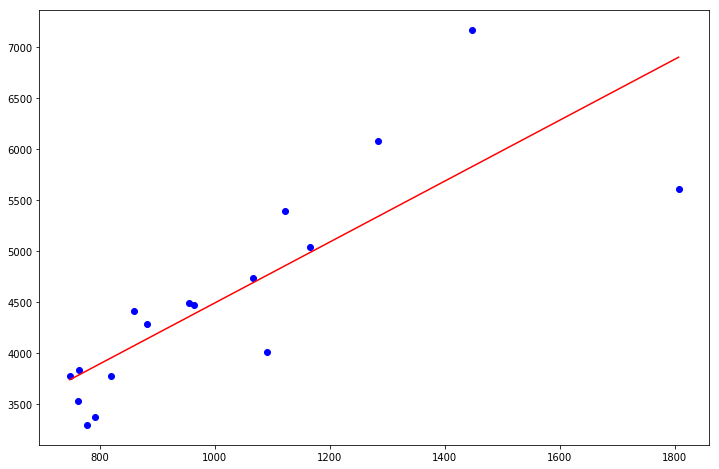

Mobile


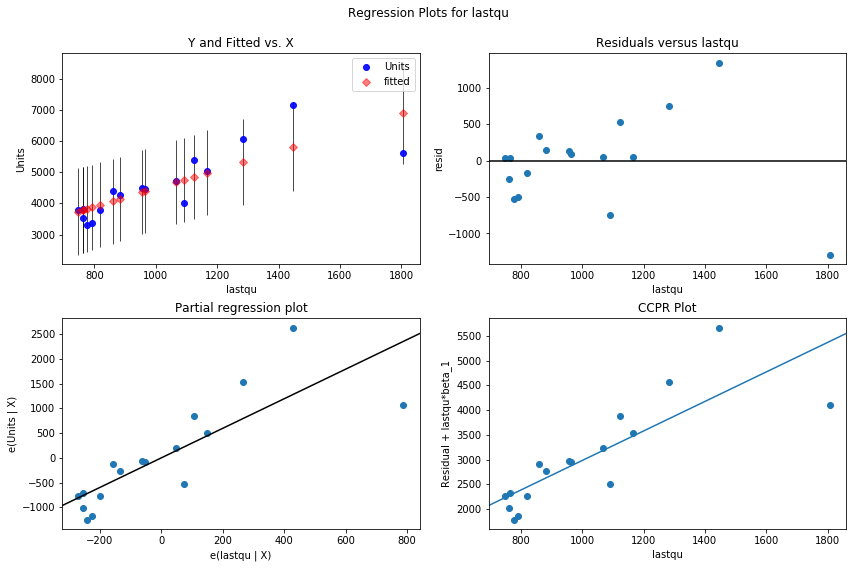

Mobile


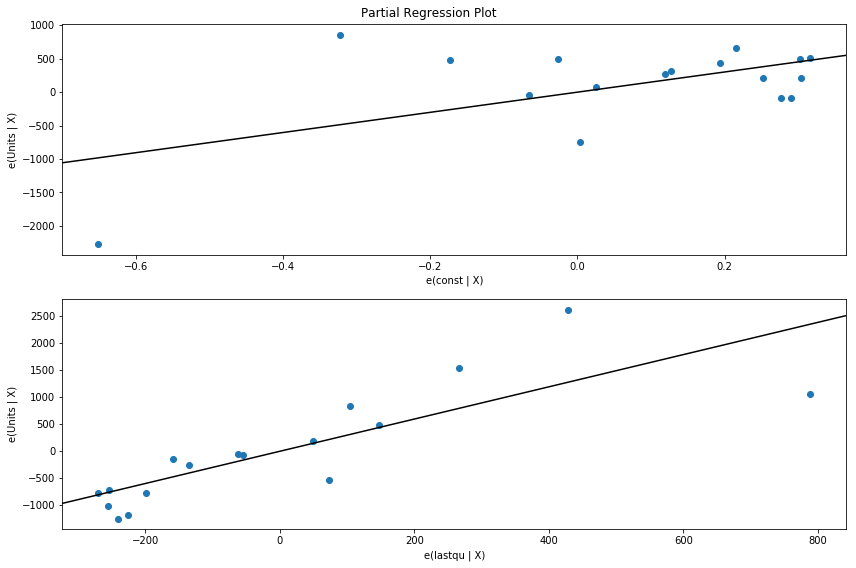

Mobile


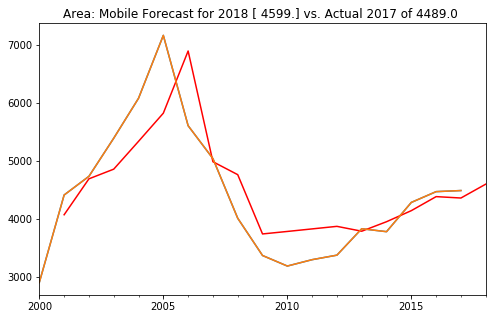

'Area fcast summary: Monroe'

'Area regress: Monroe'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     7.343
Date:                Mon, 29 Jan 2018   Prob (F-statistic):             0.0161
Time:                        16:57:20   Log-Likelihood:                -70.619
No. Observations:                  17   AIC:                             145.2
Df Residuals:                      15   BIC:                             146.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.2136     15.926      3.467      0.003      21.268      89.159
lastqu         1.8356      0.677      2.710      0.016       0.392       3.279
==============================================================================
Omnibus:                        3.771   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                1.601
Skew:                          -0.592   Prob(JB):                        0.449
Kurtosis:                       3.927   Cond. No.                         94.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Monroe'

'Area mergedfcast: Monroe'

Monroe


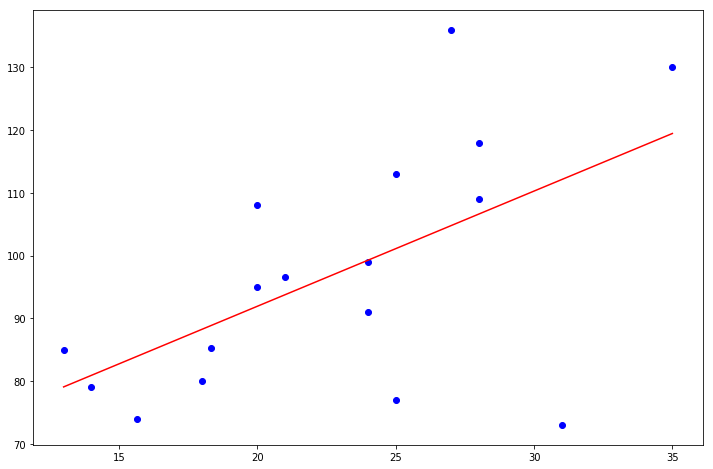

Monroe


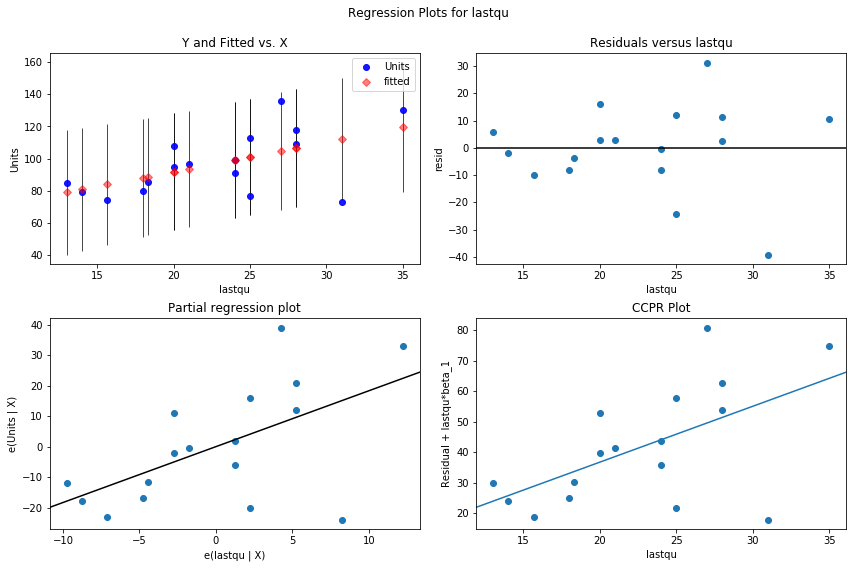

Monroe


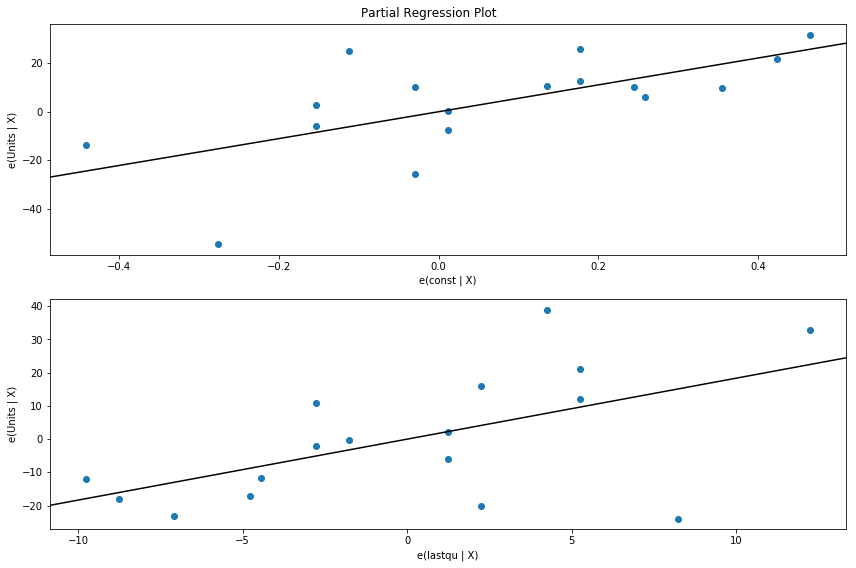

Monroe


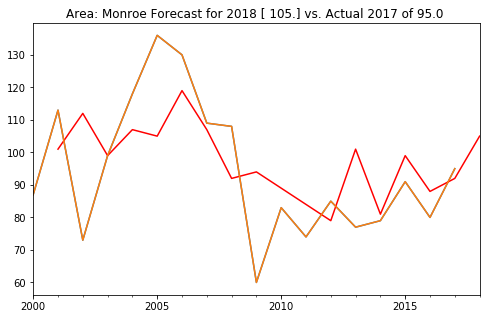

'Area fcast summary: Montgomery'

'Area regress: Montgomery'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     65.44
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           7.51e-07
Time:                        16:57:23   Log-Likelihood:                -127.33
No. Observations:                  17   AIC:                             258.7
Df Residuals:                      15   BIC:                             260.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        688.4100    460.458      1.495      0.156    -293.034    1669.854
lastqu         3.7347      0.462      8.090      0.000       2.751       4.719
==============================================================================
Omnibus:                        1.360   Durbin-Watson:                   1.162
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.332
Skew:                          -0.309   Prob(JB):                        0.847
Kurtosis:                       3.296   Cond. No.                     4.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Montgomery'

'Area mergedfcast: Montgomery'

Montgomery


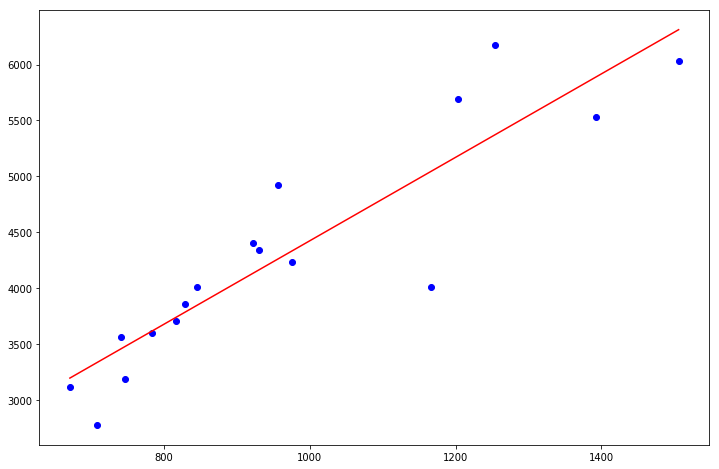

Montgomery


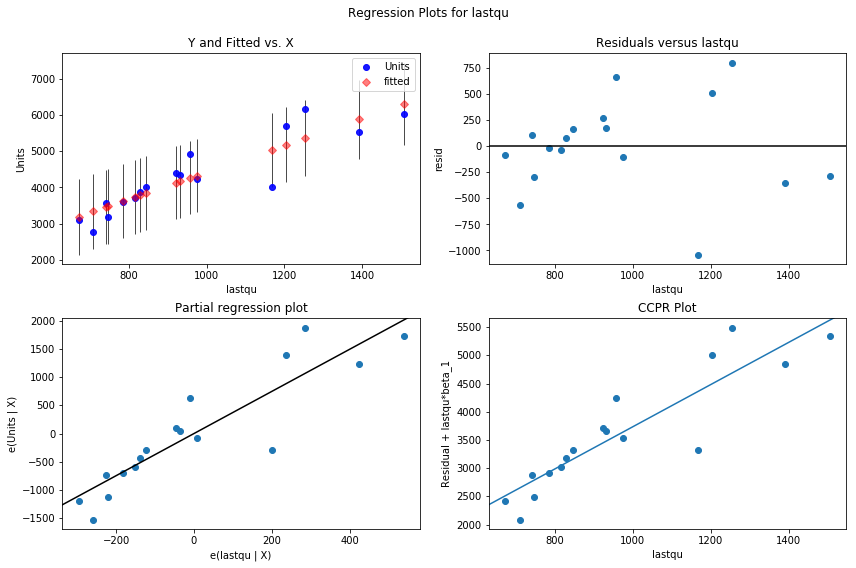

Montgomery


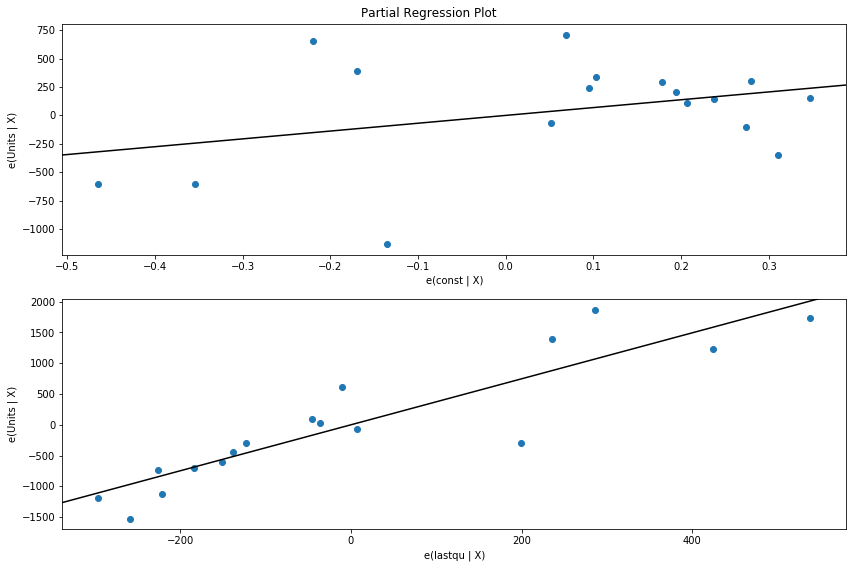

Montgomery


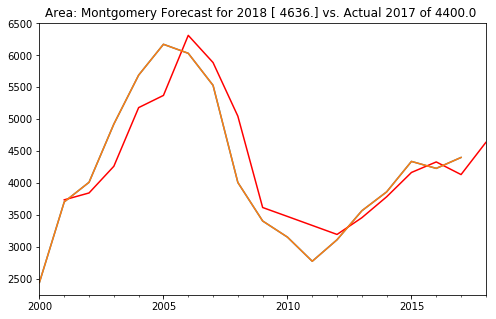

'Area fcast summary: Morgan'

'Area regress: Morgan'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     17.58
Date:                Mon, 29 Jan 2018   Prob (F-statistic):            0.00233
Time:                        16:57:27   Log-Likelihood:                -67.837
No. Observations:                  11   AIC:                             139.7
Df Residuals:                       9   BIC:                             140.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        428.0141    209.211      2.046      0.071     -45.253     901.282
lastqu         2.9823      0.711      4.192      0.002       1.373       4.592
==============================================================================
Omnibus:                        0.422   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.305
Skew:                           0.330   Prob(JB):                        0.858
Kurtosis:                       2.521   Cond. No.                     1.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Morgan'

'Area mergedfcast: Morgan'

Morgan


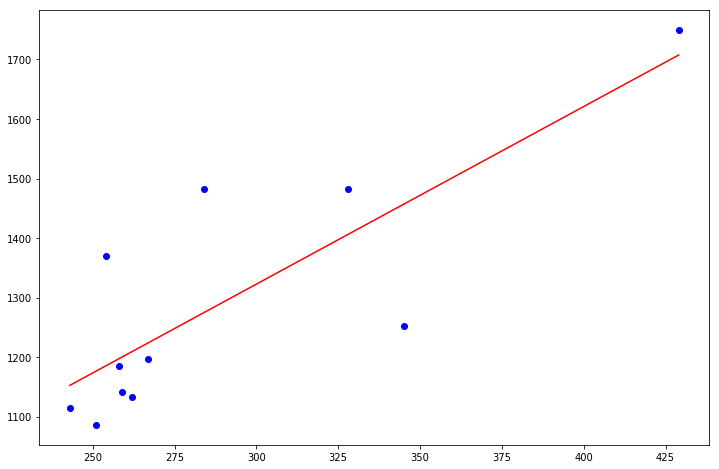

Morgan


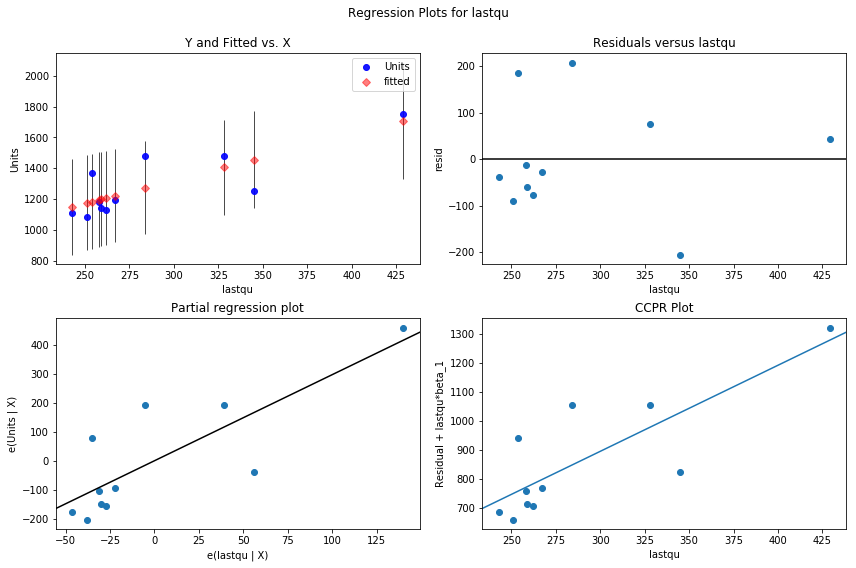

Morgan


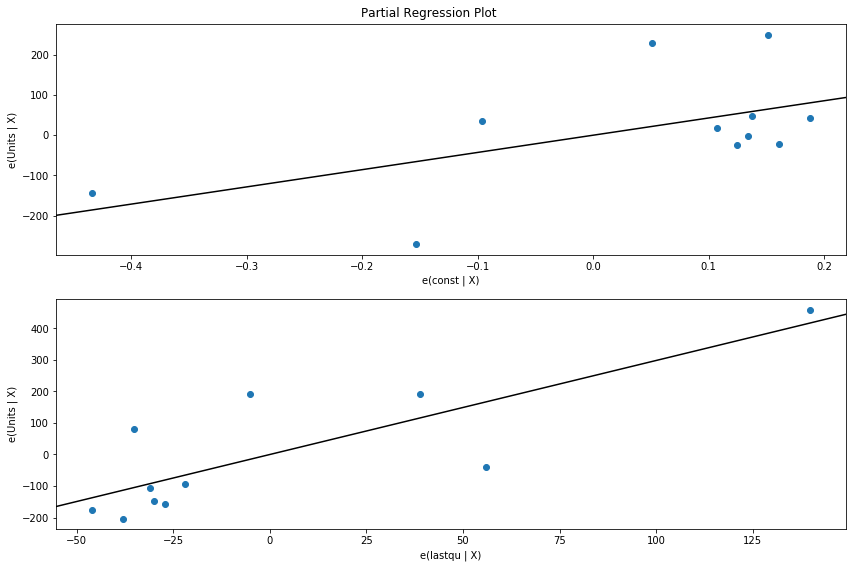

Morgan


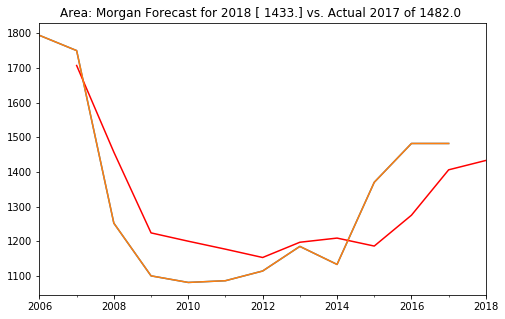

'Area fcast summary: Shoals_Area'

'Area regress: Shoals_Area'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     72.38
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           4.00e-07
Time:                        16:57:31   Log-Likelihood:                -102.43
No. Observations:                  17   AIC:                             208.9
Df Residuals:                      15   BIC:                             210.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        383.2089    124.480      3.078      0.008     117.886     648.532
lastqu         3.3117      0.389      8.508      0.000       2.482       4.141
==============================================================================
Omnibus:                        4.415   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                2.829
Skew:                          -0.999   Prob(JB):                        0.243
Kurtosis:                       3.074   Cond. No.                     1.54e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Shoals_Area'

'Area mergedfcast: Shoals_Area'

Shoals_Area


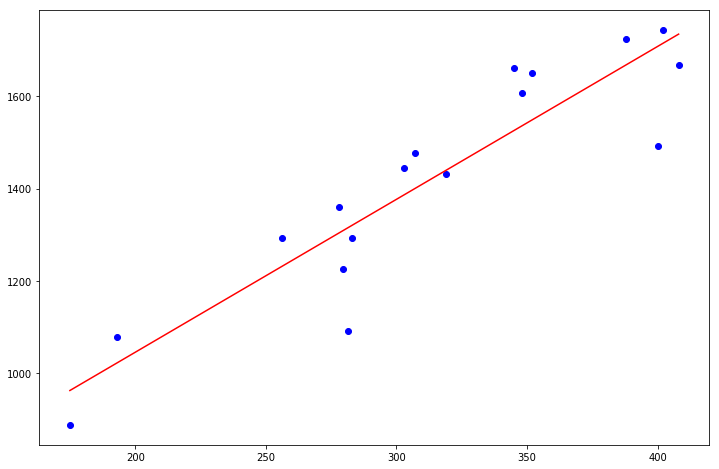

Shoals_Area


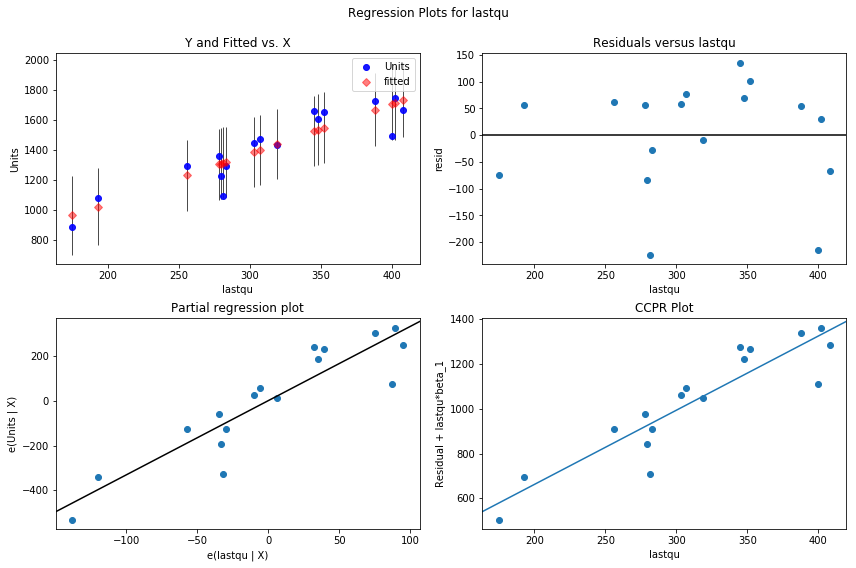

Shoals_Area


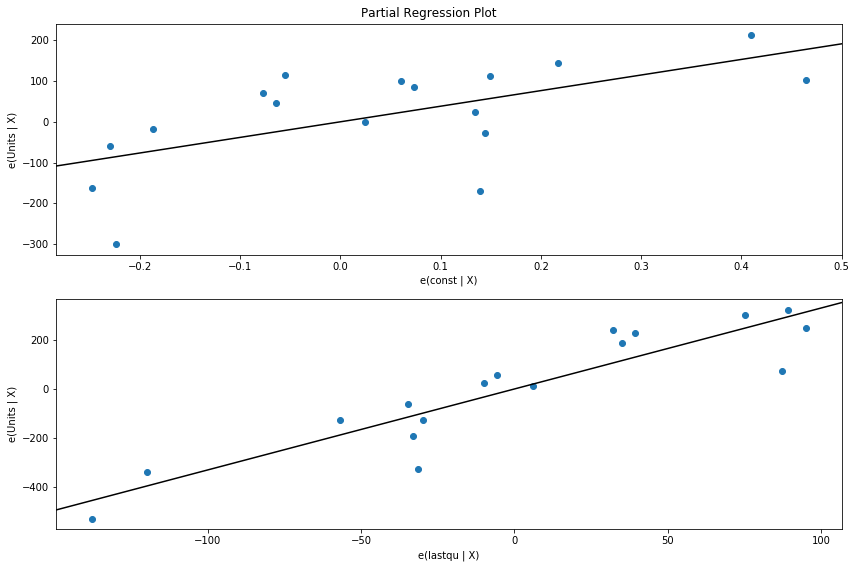

Shoals_Area


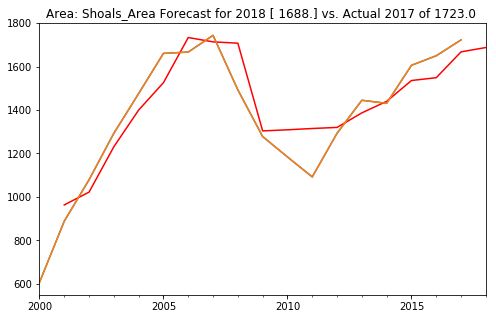

'Area fcast summary: Phenix_City'

'Area regress: Phenix_City'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     62.08
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.04e-06
Time:                        16:57:34   Log-Likelihood:                -98.325
No. Observations:                  17   AIC:                             200.7
Df Residuals:                      15   BIC:                             202.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        261.5068     94.079      2.780      0.014      60.982     462.032
lastqu         3.3896      0.430      7.879      0.000       2.473       4.307
==============================================================================
Omnibus:                        1.710   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                0.953
Skew:                          -0.145   Prob(JB):                        0.621
Kurtosis:                       1.877   Cond. No.                     1.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Phenix_City'

'Area mergedfcast: Phenix_City'

Phenix_City


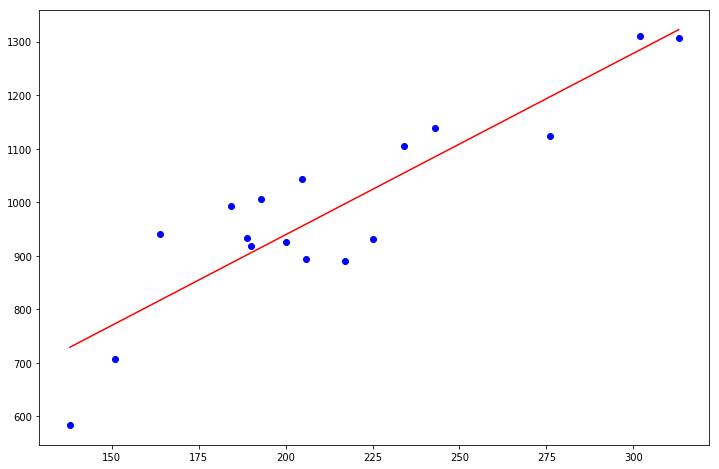

Phenix_City


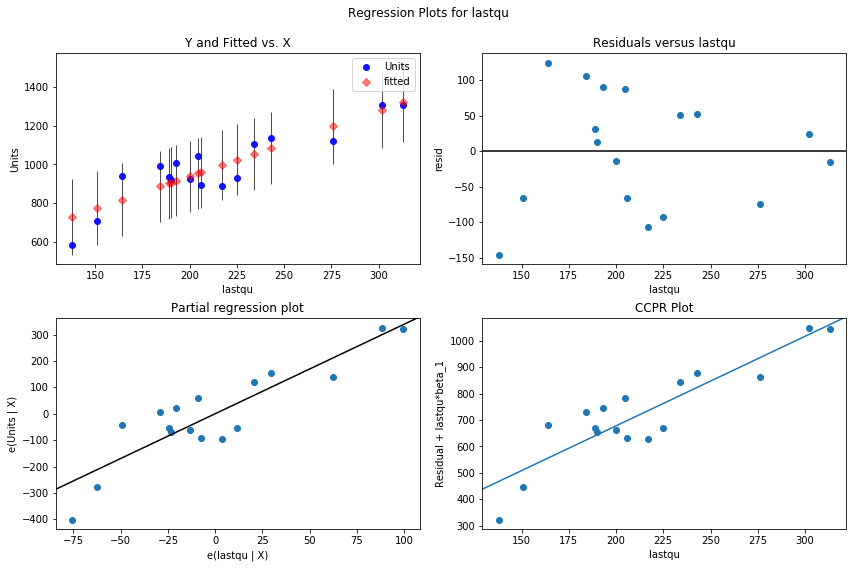

Phenix_City


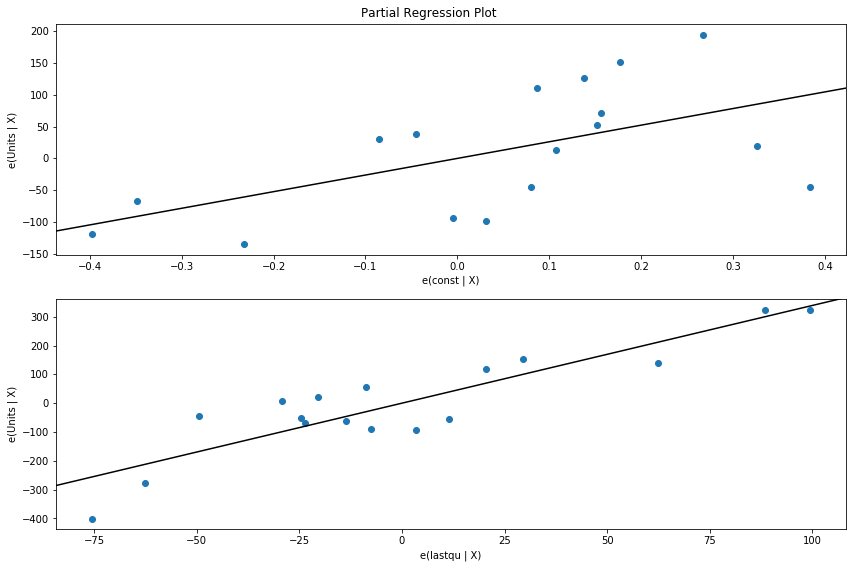

Phenix_City


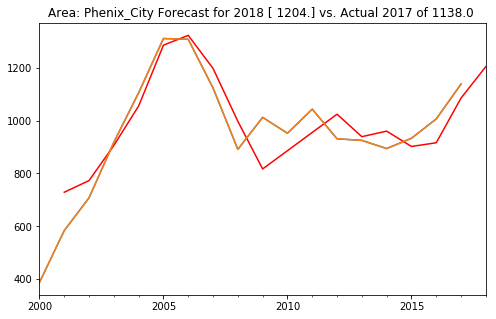

'Area fcast summary: Selma'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


'Area regress: Selma'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     19.13
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           0.000636
Time:                        16:57:37   Log-Likelihood:                -67.855
No. Observations:                  16   AIC:                             139.7
Df Residuals:                      14   BIC:                             141.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.9234     17.301      3.926      0.002      30.816     105.031
lastqu         2.4258      0.555      4.374      0.001       1.236       3.615
==============================================================================
Omnibus:                        0.383   Durbin-Watson:                   1.190
Prob(Omnibus):                  0.826   Jarque-Bera (JB):                0.082
Skew:                           0.163   Prob(JB):                        0.960
Kurtosis:                       2.870   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Selma'

'Area mergedfcast: Selma'

Selma


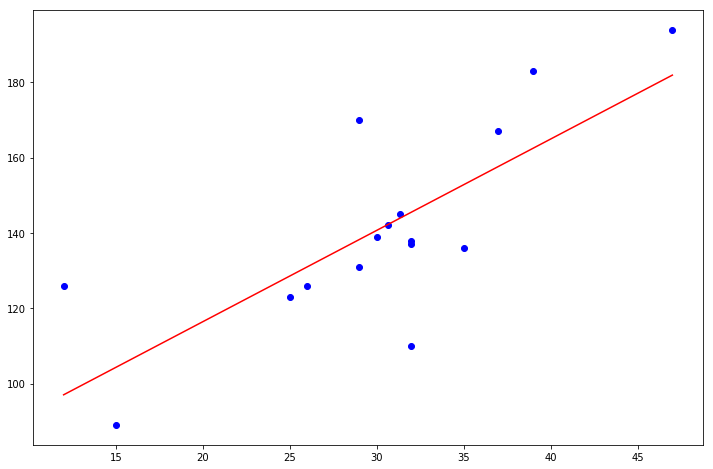

Selma


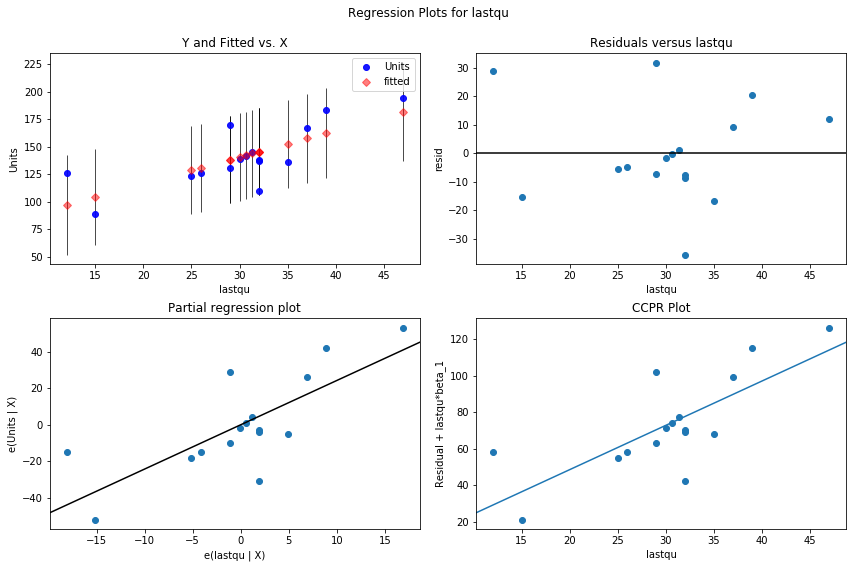

Selma


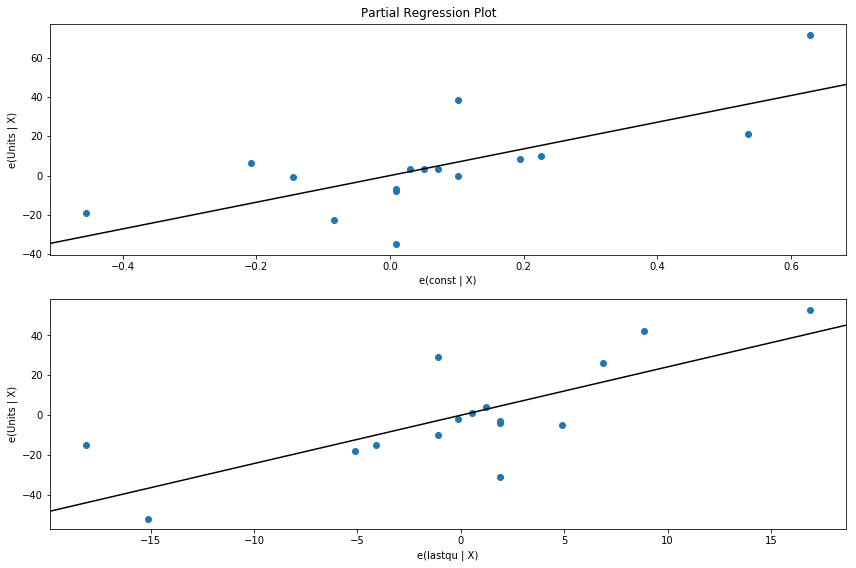

Selma


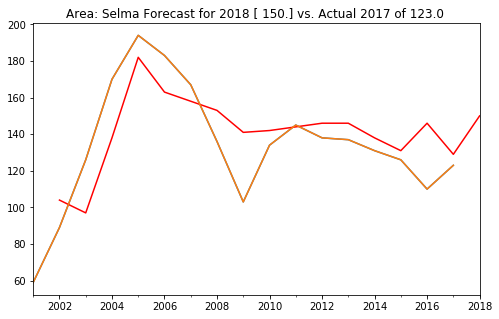

'Area fcast summary: Talladega'

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


'Area regress: Talladega'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     170.7
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.12e-06
Time:                        16:57:40   Log-Likelihood:                -48.371
No. Observations:                  10   AIC:                             100.7
Df Residuals:                       8   BIC:                             101.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3614     21.418      0.530      0.610     -38.029      60.752
lastqu         4.2861      0.328     13.065      0.000       3.530       5.043
==============================================================================
Omnibus:                        4.472   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                1.877
Skew:                           1.056   Prob(JB):                        0.391
Kurtosis:                       3.206   Cond. No.                         130.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Talladega'

'Area mergedfcast: Talladega'

Talladega


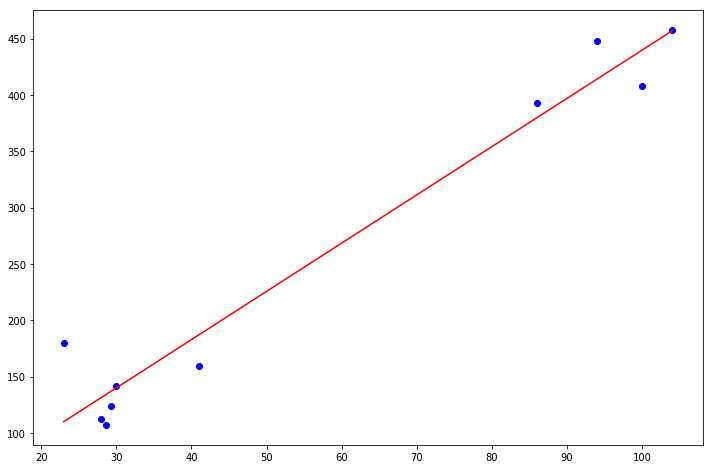

Talladega


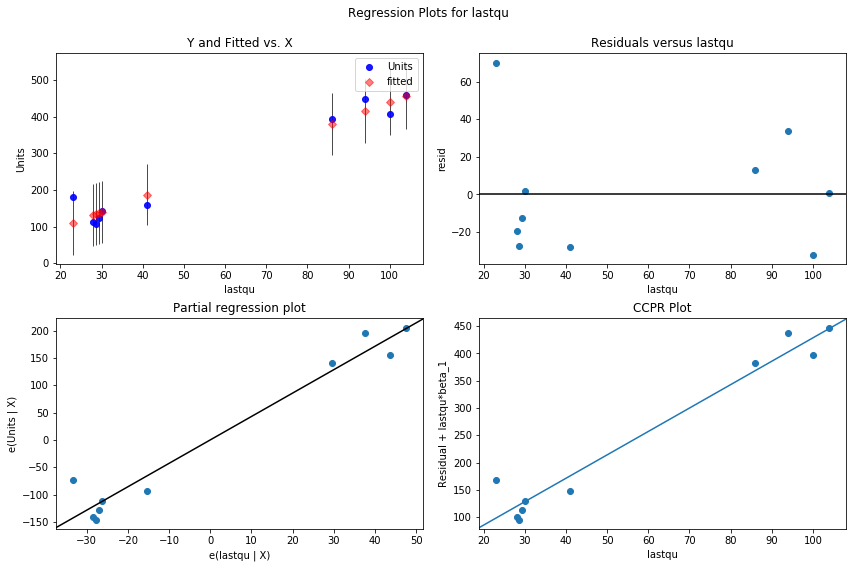

Talladega


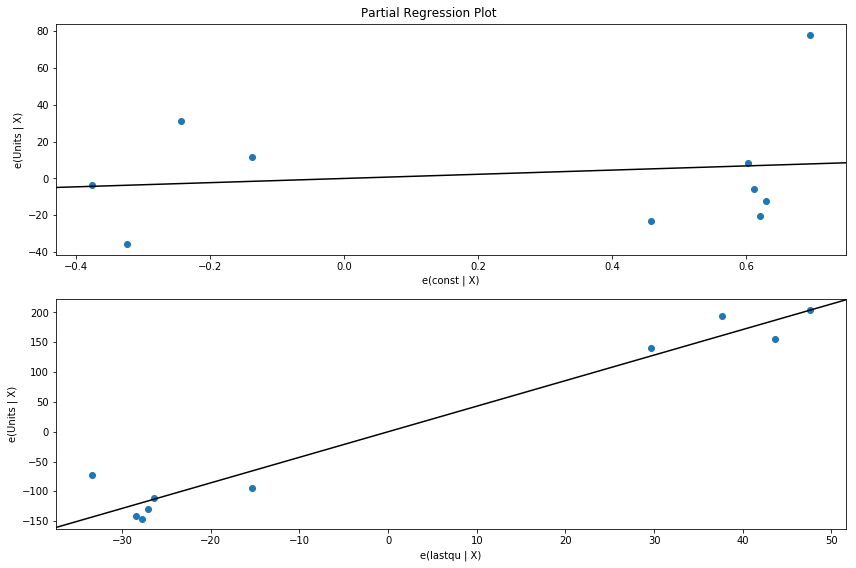

Talladega


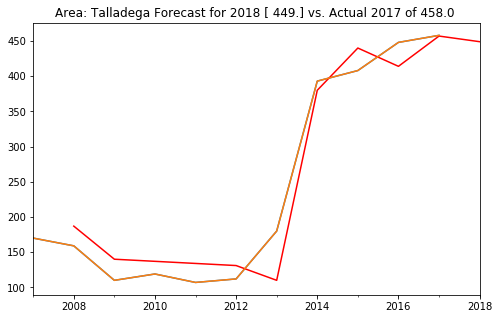

'Area fcast summary: Tuscaloosa'

'Area regress: Tuscaloosa'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     61.46
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.10e-06
Time:                        16:57:46   Log-Likelihood:                -113.15
No. Observations:                  17   AIC:                             230.3
Df Residuals:                      15   BIC:                             232.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        324.4776    217.189      1.494      0.156    -138.449     787.404
lastqu         4.1737      0.532      7.840      0.000       3.039       5.308
==============================================================================
Omnibus:                        2.270   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                0.891
Skew:                          -0.532   Prob(JB):                        0.641
Kurtosis:                       3.356   Cond. No.                     1.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Area Historical errors on Fcast: Tuscaloosa'

'Area mergedfcast: Tuscaloosa'

Tuscaloosa


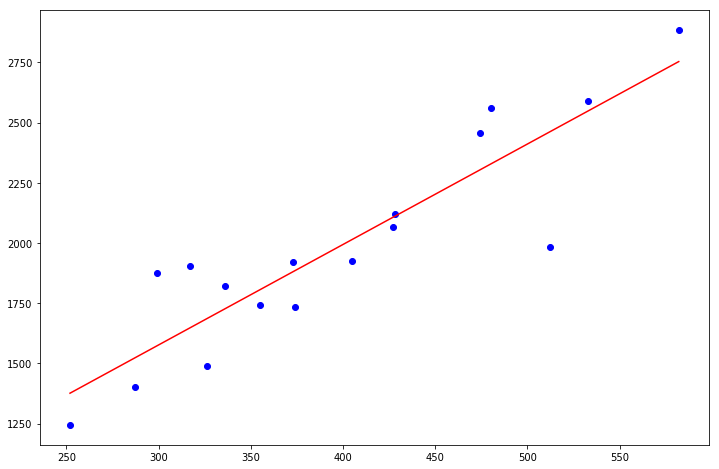

Tuscaloosa


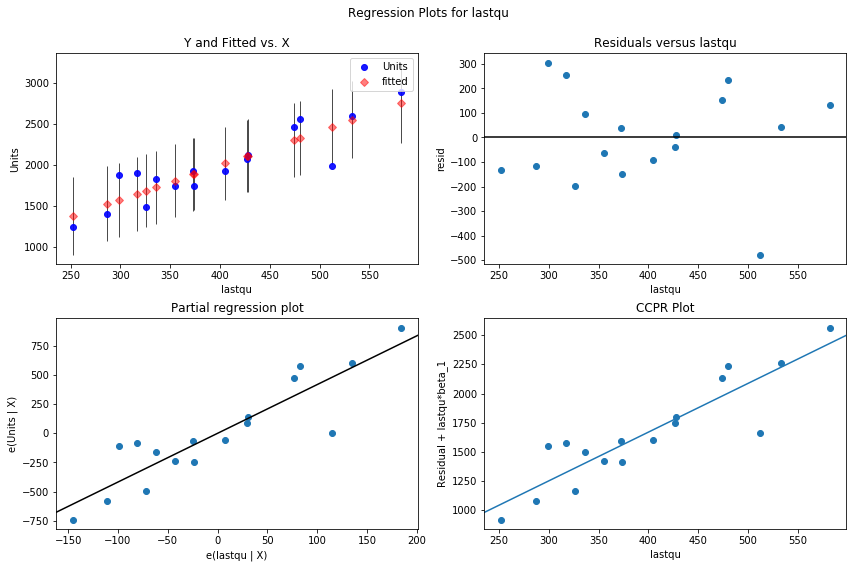

Tuscaloosa


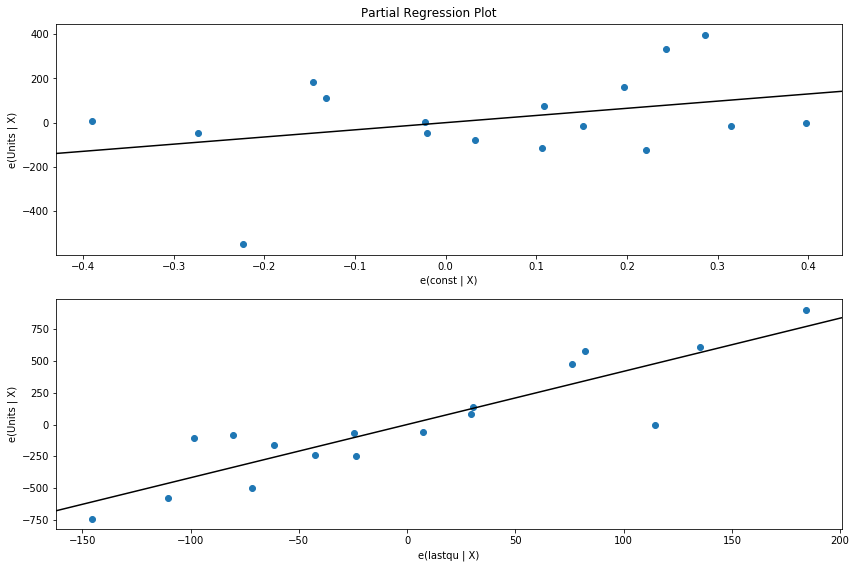

Tuscaloosa


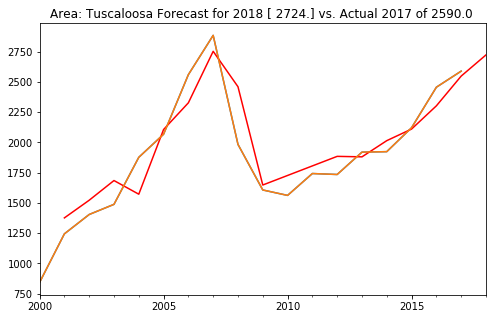

'Area fcast summary: Walker'

'Area regress: Walker'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     134.0
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           7.21e-08
Time:                        16:57:48   Log-Likelihood:                -76.759
No. Observations:                  14   AIC:                             157.5
Df Residuals:                      12   BIC:                             158.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1361     40.486     -0.275      0.788     -99.347      77.075
lastqu         4.8028      0.415     11.576      0.000       3.899       5.707
==============================================================================
Omnibus:                        1.021   Durbin-Watson:                   2.585
Prob(Omnibus):                  0.600   Jarque-Bera (JB):                0.885
Skew:                          -0.435   Prob(JB):                        0.643
Kurtosis:                       2.128   Cond. No.                         235.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Walker'

'Area mergedfcast: Walker'

Walker


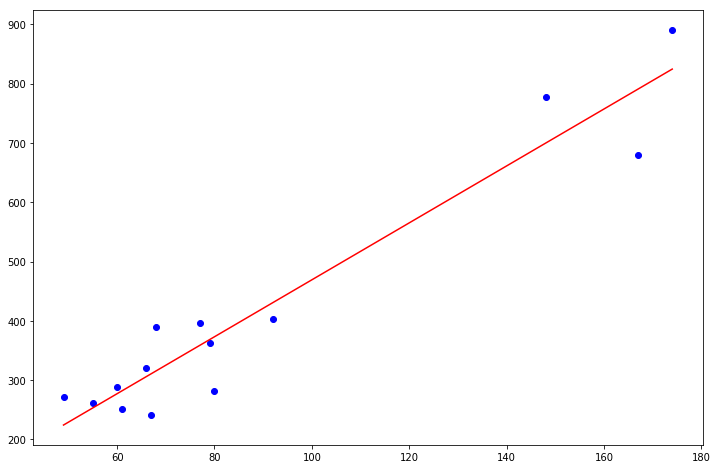

Walker


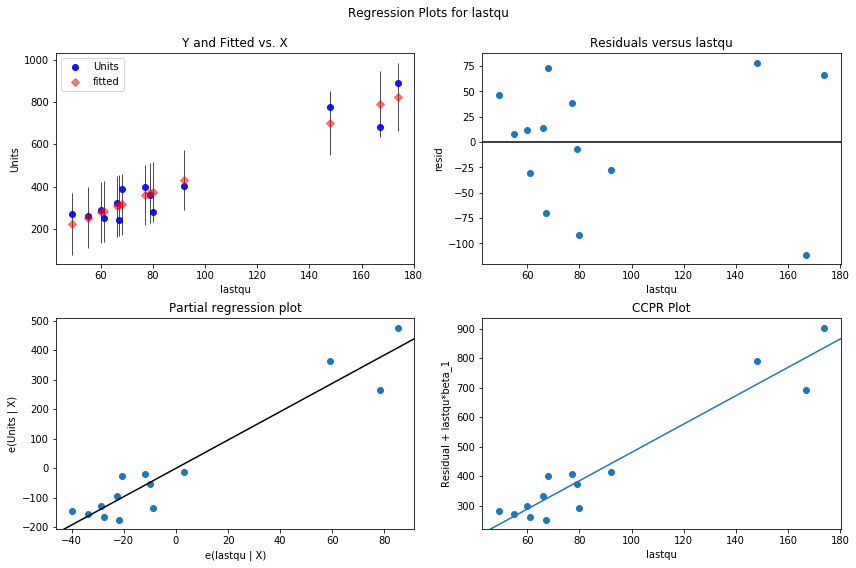

Walker


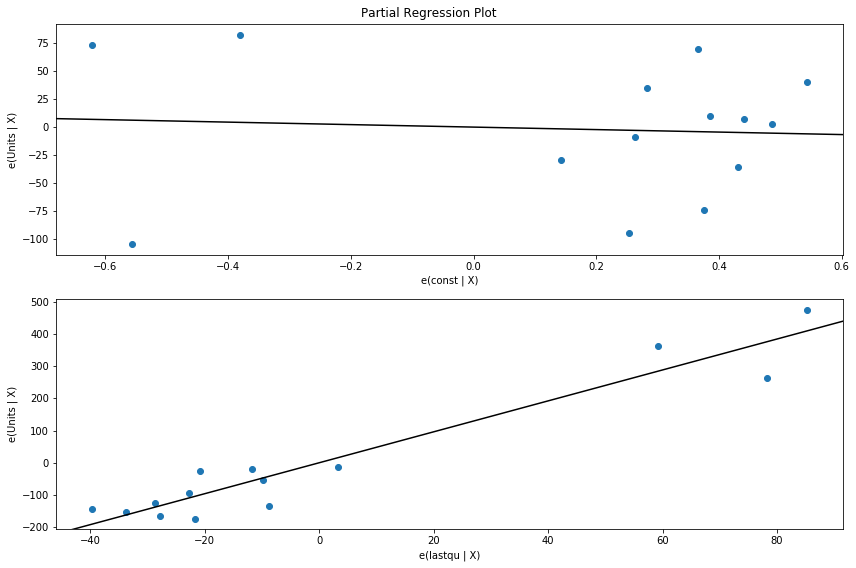

Walker


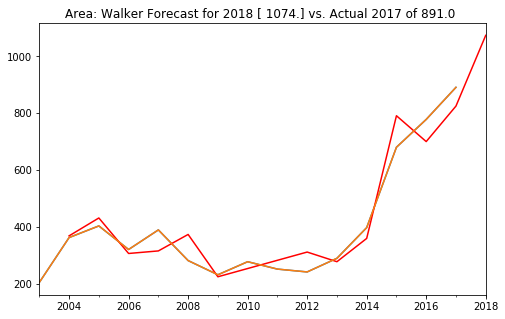

'Area fcast summary: Wiregrass'

'Area regress: Wiregrass'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     40.64
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           1.25e-05
Time:                        16:57:52   Log-Likelihood:                -100.96
No. Observations:                  17   AIC:                             205.9
Df Residuals:                      15   BIC:                             207.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        218.6970    100.712      2.172      0.046       4.035     433.360
lastqu         3.5126      0.551      6.375      0.000       2.338       4.687
==============================================================================
Omnibus:                        1.469   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.480   Jarque-Bera (JB):                0.365
Skew:                          -0.316   Prob(JB):                        0.833
Kurtosis:                       3.342   Cond. No.                         777.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Wiregrass'

'Area mergedfcast: Wiregrass'

Wiregrass


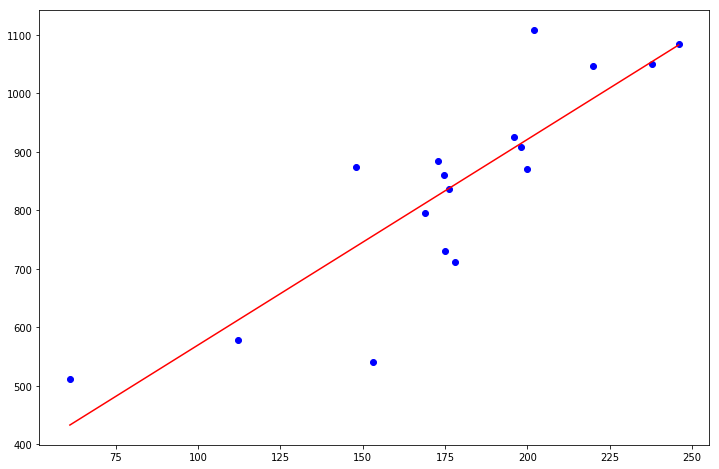

Wiregrass


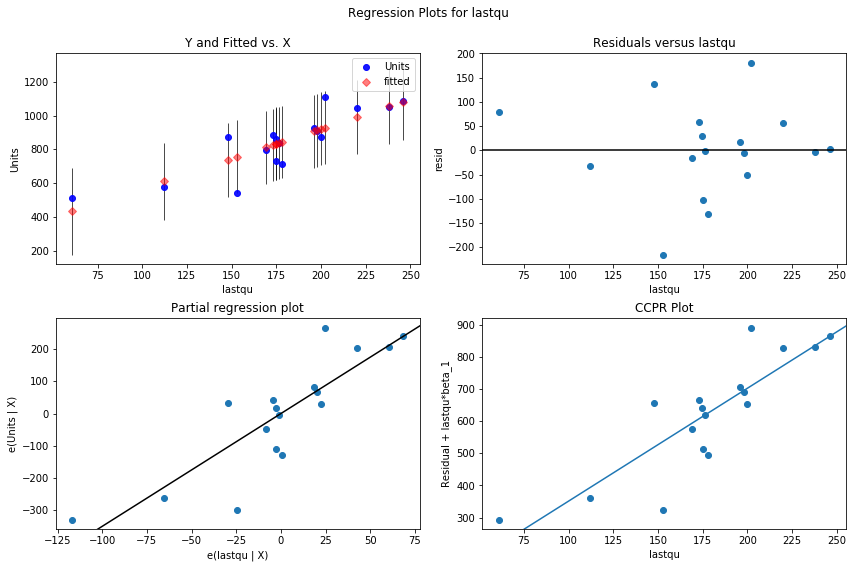

Wiregrass


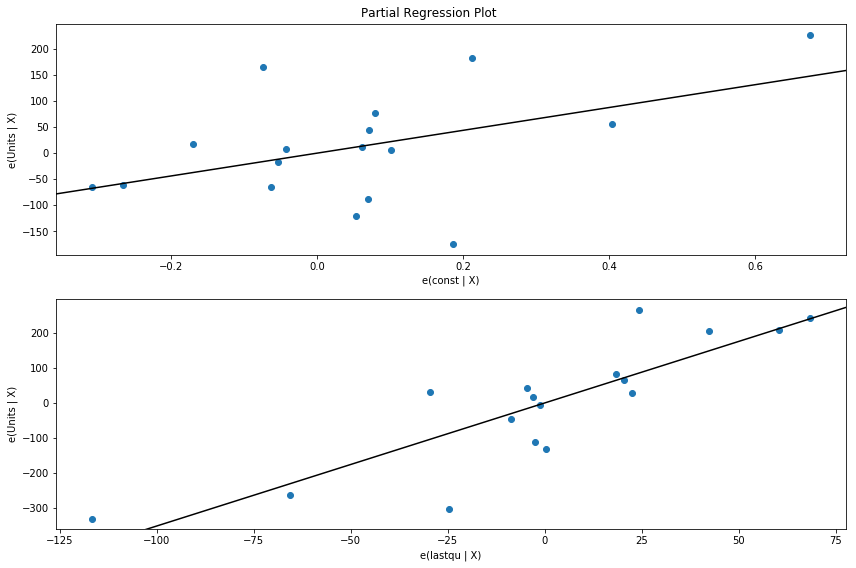

Wiregrass


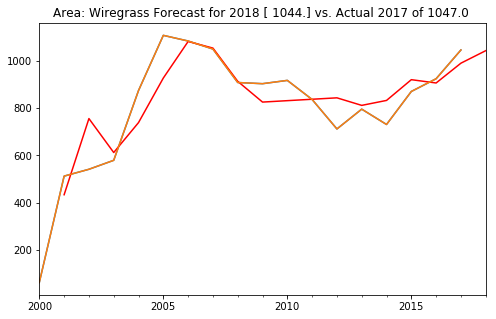

'Area fcast summary: Lake_Martin_Waterfront'

'Area regress: Lake_Martin_Waterfront'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Units   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     16.06
Date:                Mon, 29 Jan 2018   Prob (F-statistic):            0.00391
Time:                        16:57:55   Log-Likelihood:                -51.508
No. Observations:                  10   AIC:                             107.0
Df Residuals:                       8   BIC:                             107.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.3631     37.313      2.985      0.017      25.320     197.406
lastqu         3.3497      0.836      4.008      0.004       1.422       5.277
==============================================================================
Omnibus:                        1.708   Durbin-Watson:                   2.319
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.101
Skew:                           0.745   Prob(JB):                        0.577
Kurtosis:                       2.348   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Area Historical errors on Fcast: Lake_Martin_Waterfront'

'Area mergedfcast: Lake_Martin_Waterfront'

Lake_Martin_Waterfront


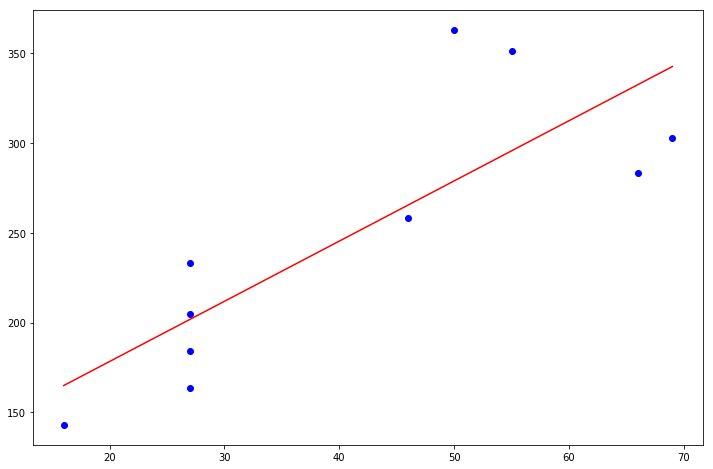

Lake_Martin_Waterfront


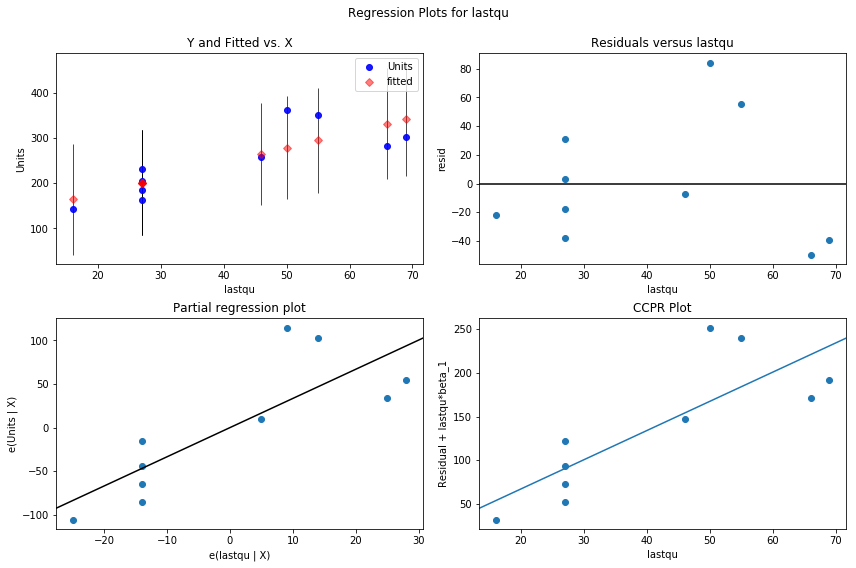

Lake_Martin_Waterfront


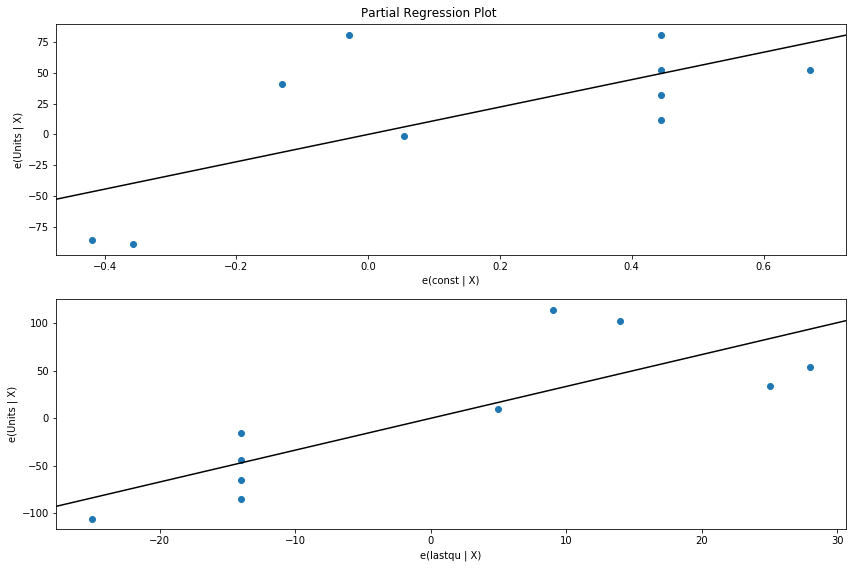

Lake_Martin_Waterfront


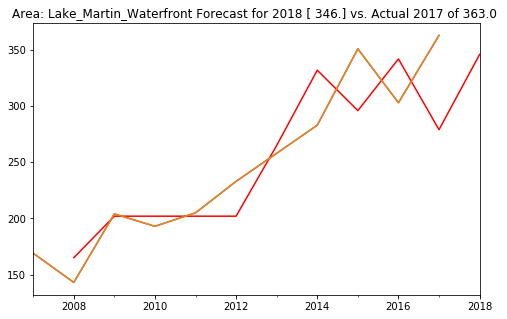

In [14]:
#DIAGNOSTICS!! 
#area_tabs=[3] # the specific tab numbers 
#17=Mobile
#25=Tuscaloosa
#area_tabs=['2','3','4','5','12','25'] # the tab numbers
area_tabs=list(map(int, range(1, 29)))
for area_tabs in area_tabs:
    fig = plt.figure(figsize=(12,8))
    actdf,aname = get_data(area_tabs)
    dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
    IPython.display.display('Area fcast summary: %s' % aname, mergederrs.tail(12))
#    IPython.display.display('Pearson Correlation %s' % aname)
#    IPython.display.display(merged2[:-1].corr(method='pearson'))
#    IPython.display.display('Area 2004 & newer: %s' % aname,merged2['2004-12-31':'1'].corr(method='pearson'))
    IPython.display.display('Area regress: %s' % aname, ols_test.summary())
    IPython.display.display('Area Historical errors on Fcast: %s' % aname, merged2)
    IPython.display.display('Area mergedfcast: %s' % aname, mergedfcst.tail(12))
#    IPython.display.display(aname) 
    aname,regress=regressplot(aname,ols_test)
    fig.clf() #clears the fig!
    print (aname)
    IPython.display,display(sm.graphics.plot_regress_exog(ols_test, 'lastqu', fig=fig))
    fig.clf() #clears the fig!
    print (aname)
    IPython.display,display(sm.graphics.plot_partregress_grid(ols_test, fig=fig))
    fig.clf() #clears the fig!
#    IPython.display.display(aname)
    print (aname)
    fig = plt.figure(figsize=(8,5))
    ax=fullyrs.Units[:-1].plot()
    ax=merged2.fcast.plot(style='r')
    lastyrtot=str(merged2['Units'][-2:-1].iloc[0])
    fig=fullyrs.Units.plot(ax=ax, title='Area: {0} Forecast for 2018 {1} vs. Actual 2017 of {2} '.format(unicode(aname),unicode(merged2['fcast'][-1:].values),
lastyrtot))
    show(fig)
#    IPython.display.display(fig)

/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Lake_Martin_Waterfront
            predictor    response
2008-12-31       16.0  143.000000
2009-12-31       27.0  163.666667
2010-12-31       27.0  184.333333
2011-12-31       27.0  205.000000
2012-12-31       27.0  233.000000
2013-12-31       46.0  258.000000
2014-12-31       66.0  283.000000
2015-12-31       55.0  351.000000
2016-12-31       69.0  303.000000
2017-12-31       50.0  363.000000
                 Units  predictor  Uperchg  lqperchg  fcast  errpercent  \
2007-12-31  169.000000        NaN      NaN       NaN    NaN         NaN   
2008-12-31  143.000000       16.0   -15.38       NaN  165.0       13.33   
2009-12-31  163.666667       27.0    14.45     68.75  202.0       18.98   
2010-12-31  184.333333       27.0    12.63      0.00  202.0        8.75   
2011-12-31  205.000000       27.0    11.21      0.00  202.0       -1.49   
2012-12-31  233.000000       27.0    13.66      0.00  202.0      -15.35   
2013-12-31  258.000000       46.0    10.73     70.37  265.0        2.64   
201

/home/tom/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


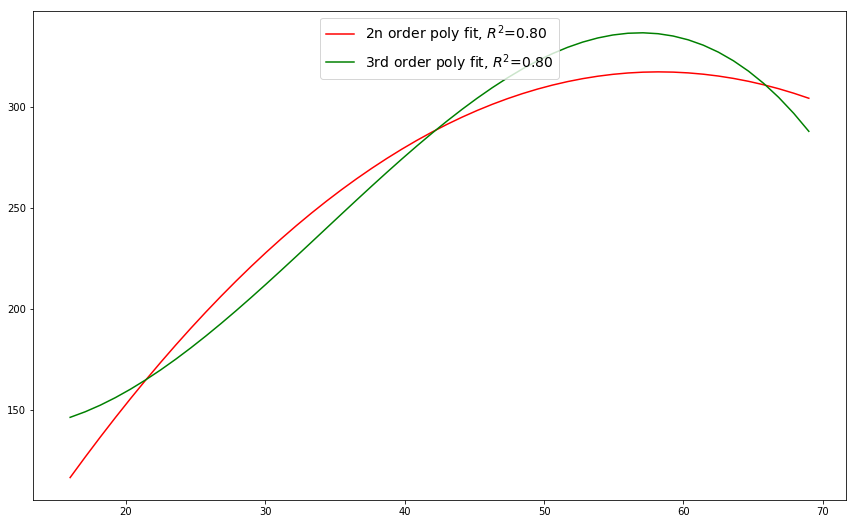

In [15]:
#Lets try statsmodele formula interface for poynomial LR 

dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
dfform.columns = ['predictor','response']
df = dfform[1:]
print (aname)
print (df)


#df = pd.DataFrame({'predictor': x, 'response': y})

x1 = pd.DataFrame({'predictor': np.linspace(df.predictor.min(), df.predictor.max())})

#poly_1 = smf.ols(formula='response ~ 1 + predictor', data=df).fit()
poly_2 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0)', data=df).fit()
poly_3 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0) + I(predictor ** 3.0)', data=df).fit()
merged2.columns = ['Units','predictor','Uperchg','lqperchg','fcast','errpercent','nfcast','fctperchg']
print (merged2)
predictor=merged2.predictor
yrahead=poly_3.predict(predictor)
print(yrahead)
#print ('POLY1 SUMMARY: %s' % poly_1.summary())
print ('POLY2 SUMMARY: %s' % poly_2.summary())
print ('POLY3 SUMMARY: %s' % poly_3.summary())


plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x1.predictor, poly_2.predict(x1), 'r-', 
         label='2n order poly fit, $R^2$=%.2f' % poly_2.rsquared)
#plt.plot(x1.predictor, poly_2.predict(x1), 'b-', 
#         label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared)
plt.plot(x1.predictor, poly_3.predict(x1), 'g-', 
         label='3rd order poly fit, $R^2$=%.2f' % poly_2.rsquared)

#plt.plot(x, y, 'o', alpha=0.2)
plt.legend(loc="upper center", fontsize=14)
plt.show()

/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Lake_Martin_Waterfront
            predictor    response
2008-12-31       16.0  143.000000
2009-12-31       27.0  163.666667
2010-12-31       27.0  184.333333
2011-12-31       27.0  205.000000
2012-12-31       27.0  233.000000
2013-12-31       46.0  258.000000
2014-12-31       66.0  283.000000
2015-12-31       55.0  351.000000
2016-12-31       69.0  303.000000
2017-12-31       50.0  363.000000
POLY2 SUMMARY:                             OLS Regression Results                            
Dep. Variable:               response   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     14.09
Date:                Mon, 29 Jan 2018   Prob (F-statistic):            0.00352
Time:                        16:57:56   Log-Likelihood:                -48.942
No. Observations:                  10   AIC:                             103.9
Df Residuals:                      

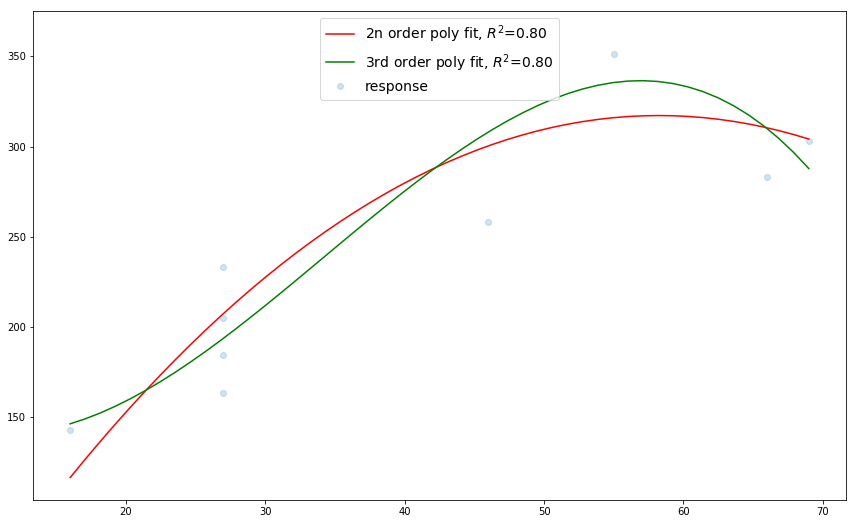

In [16]:
dfform,fullyrs,lastq,fcast_yr,projections,yrahead,aname,actdf,merged2,mergederrs,montdist,ols_test,mergedfcst,curr_month=do_projections(actdf,aname)
dfform.columns = ['predictor','response']
df = dfform[1:]
print (aname)
print (df)

x1 = pd.DataFrame({'predictor': np.linspace(df.predictor.min(), df.predictor.max())})
poly_2 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0)', data=df).fit()
poly_3 = smf.ols(formula='response ~ 1 + predictor + I(predictor ** 2.0) + I(predictor ** 3.0)', data=df).fit()
print ('POLY2 SUMMARY: %s' % poly_2.summary())
print ('POLY3 SUMMARY: %s' % poly_3.summary())

plt.figure(figsize=(9 * 1.618, 9))
plt.plot(x1.predictor, poly_2.predict(x1), 'r-', 
         label='2n order poly fit, $R^2$=%.2f' % poly_2.rsquared)
plt.plot(x1.predictor, poly_3.predict(x1), 'g-', 
         label='3rd order poly fit, $R^2$=%.2f' % poly_2.rsquared)

#plt.plot(x, y, 'o', alpha=0.2)
plt.plot(df.predictor, df.response, 'o', alpha=0.2)
plt.legend(loc="upper center", fontsize=14)
plt.show()

Lake_Martin_Waterfront


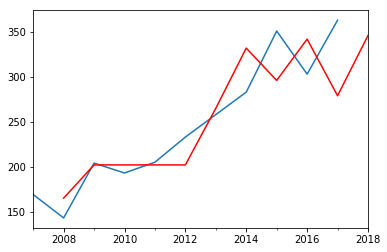

In [17]:
#this just shows the regression results with current yr fcast
print (aname)
fig = plt.figure(figsize=(6,4))
ax=fullyrs.Units[:-1].plot()
ax=merged2.fcast.plot(style='r')

Lake_Martin_Waterfront


AttributeError: module 'pandas' has no attribute 'rolling_mean'

<Figure size 432x288 with 0 Axes>

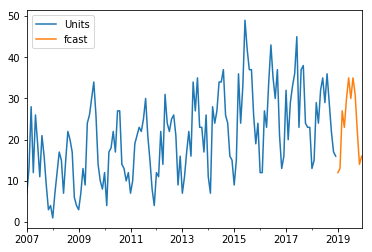

In [69]:
print (aname)
fig = plt.figure(figsize=(6,4))
ax = mergedfcst.plot()
ax = (pd.rolling_mean(mergedfcst,12).plot(ax=ax,style='r'))
ax.xaxis.grid(True, which='both')
#fix legend, and see if can extend rolling mean..
#with 12 month moving avg 

To suppress the code cells (only input) a custom template can be used. Similar as discussed in this question, a template e.g. latex_nocode.tplx has to be created (in the working directory) with the following content
((*- extends 'latex_article.tplx' -*))
% Disable input cells
((* block input_group *))
((* endblock input_group *))
use this template like
ipython nbconvert --to=latex --template=latex_nocode.tplx --post=pdf file.ipynb

In [ ]:
#!ipython nbconvert --to=latex --template=latex_nocode.tplx --post=pdf June_2014FcastUnivPubmdBald.ipynb

In [22]:
!ipython nbconvert --to=latex --template=latex_nocode.tplx 2018FcastUniv.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook 2018FcastUniv.ipynb to latex
/home/tom/anaconda3/lib/python3.6/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.jupyter.widget-view+json']) is not able to be represented.
  mimetypes=output.keys())
/home/tom/anaconda3/lib/python3.6/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.jupyter.widget-view+json']) is not able to be represented.
  mimetypes=output.keys())
/home/tom/anaconda3/lib/python3.6/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.jupyter.widget-view+json']) is not able to be represented.
  mimetypes=output.keys(